### <span style="color:teal"> __UNIPARTITE - DISEASE NETWORK ANALYSIS__ 

<span style="color:teal"> In a disease‐centric unipartite species network, diseases are represented as nodes, and an edge is drawn between two diseases when they share one or more microbial genera with statistically significant associations. This projection is derived from an underlying disease–species bipartite network, where the intermediate microbial genera serve as the basis for linking diseases. Such a network highlights the similarity in microbial profiles between different diseases, capturing patterns of shared dysbiosis. By focusing on disease–disease connections, it allows us to explore potential comorbidity patterns, identify disease clusters with overlapping microbial signatures, and generate hypotheses about common pathophysiological mechanisms that may be mediated by the gut microbiome. This approach shifts the perspective from individual taxa to the broader relationships between diseases, providing a systems‐level view of microbiome–host interactions.


In [26]:

# LOADING REQUIRED PACKAGES
import pickle
from collections import Counter
import itertools
import json
import powerlaw
from kneed import KneeLocator
import pickle

# NetworkX and Seaborn
from networkx.algorithms import bipartite
import seaborn as sns
from collections import defaultdict

# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch

import matplotlib.ticker as ticker 

from adjustText import adjust_text
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain  # Louvain community detection (python-louvain)
import textwrap
# Optional: Configure matplotlib to use a specific style or suppress warnings
# plt.style.use('seaborn-whitegrid')  # optional, if you want a consistent style


powerlaw.__version__  # Check the version of powerlaw package

'1.4.4'

In [27]:
# LOADING THE UNIPARTITE DISEASE _species PROJECTION NETWORK
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/network_analysis/bipartite_species_network.gpickle", "rb") as f:
    B_species = pickle.load(f)

In [28]:
# Open the JSON file containing disease name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gut_microbiome_project/resources/disease_dict.json", "r") as f:
    disease_dict = json.load(f)

# Load the phenotype mapping JSON
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_classification.json", "r") as f:
    disease_category_by_id = json.load(f)


=== Network Summary ===
Number of nodes: 65
Number of edges: 2041
Degree range: (56.0, 64.0)
Edge weight range: (1.0, 113.0)


/tmp/slurm.4730828/ipykernel_3960228/304545980.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("inferno")


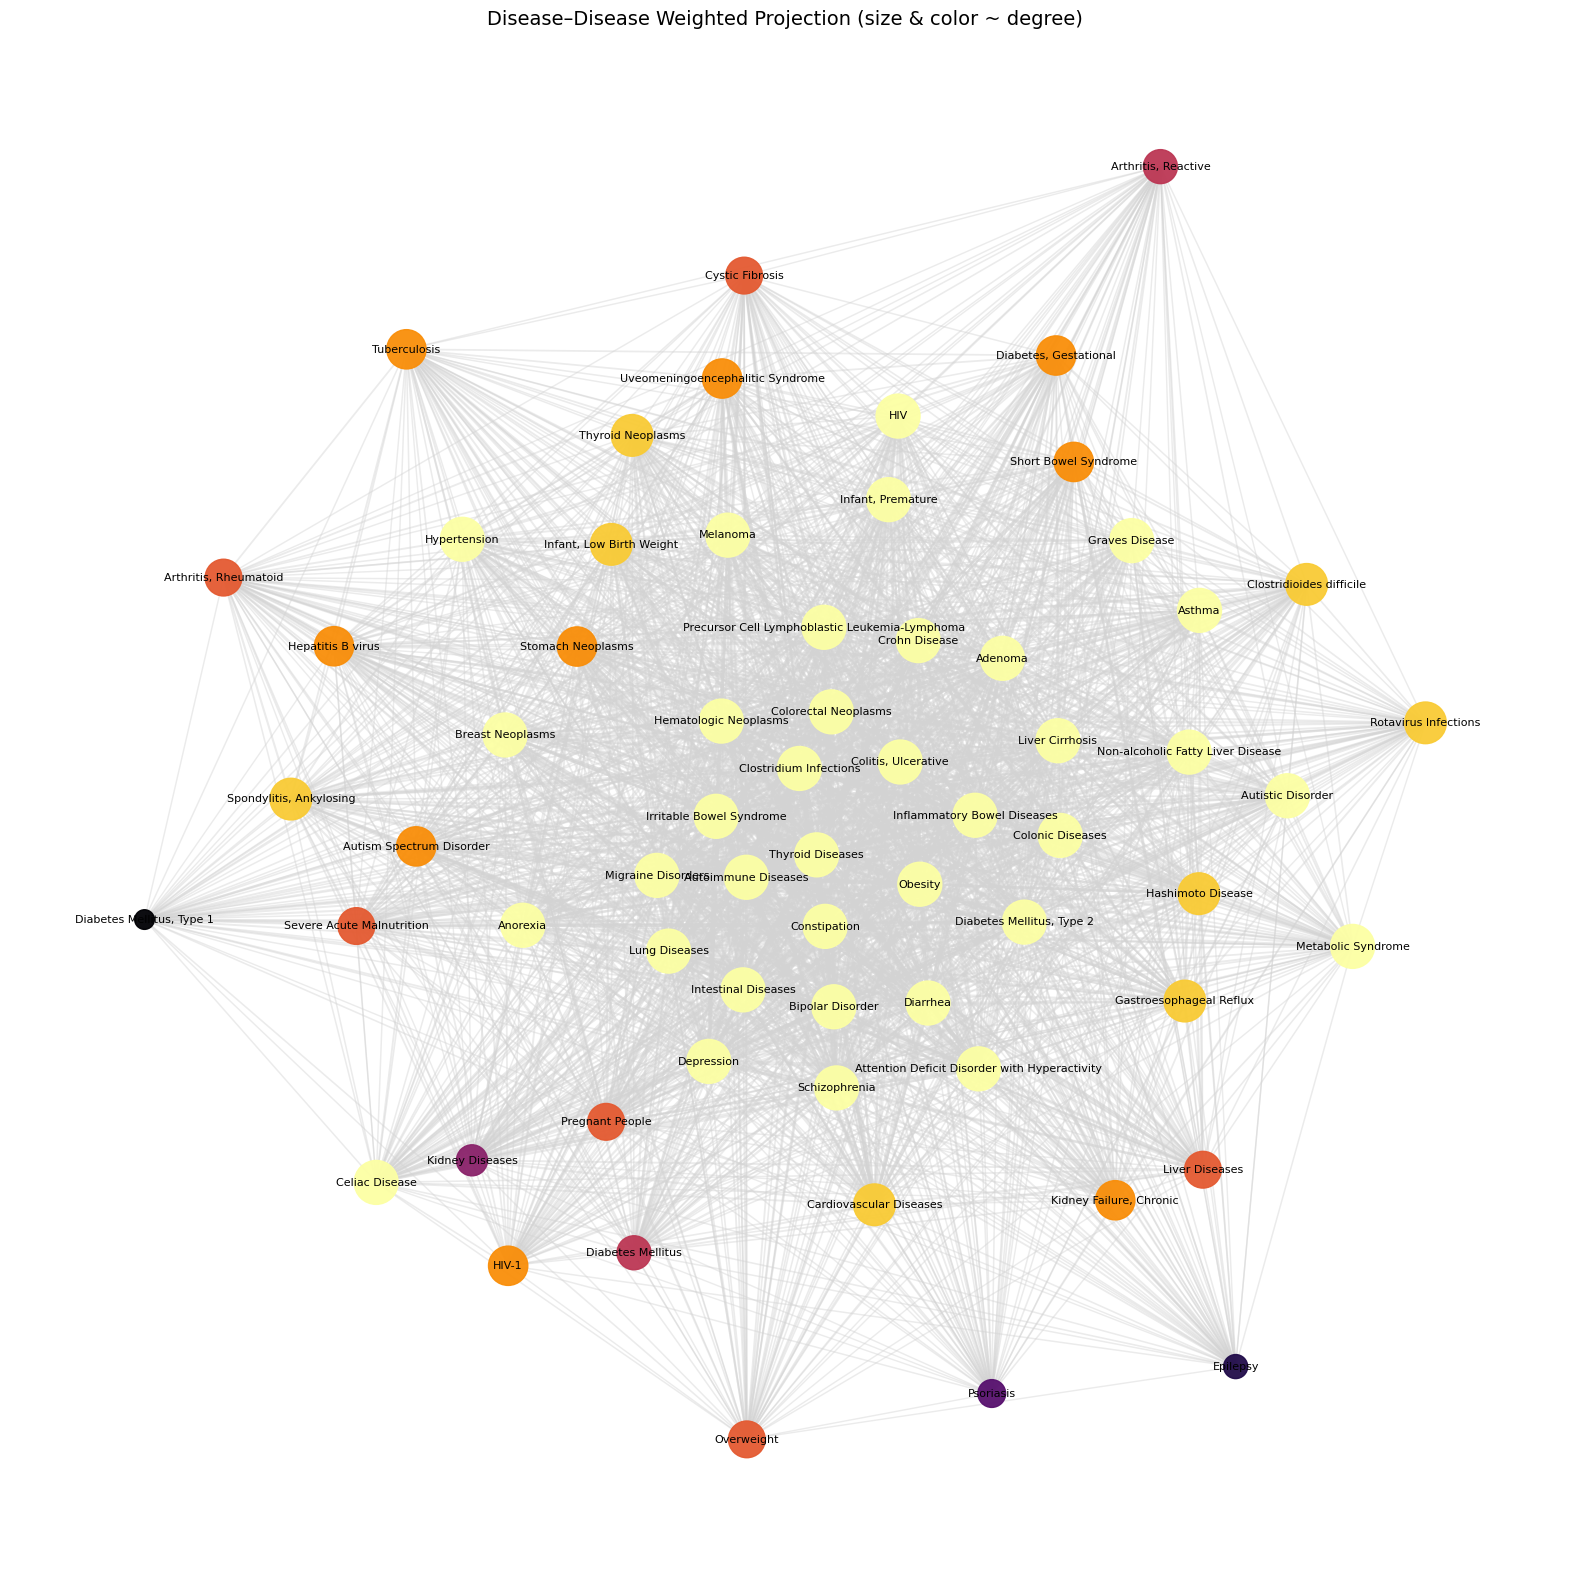

In [29]:
# BIPARTITE DISEASE DIEASE NETWORK
# --- Partitions from B_species (assumes bipartite attr: 0=diseases, 1=taxa) ---
diseases = {n for n, d in B_species.nodes(data=True) if d.get("bipartite") == 0}
if not diseases:
    raise ValueError("No disease nodes found with bipartite==0 in B_species.")

# --- Weighted unipartite projection: disease–disease (weight = shared taxa count) ---
G = bipartite.weighted_projected_graph(B_species, diseases)

# === Summary stats ===
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (deg_vals.min() if deg_vals.size else None,
                     deg_vals.max() if deg_vals.size else None),
    "Edge weight range": (weights.min() if weights.size else None,
                          weights.max() if weights.size else None)
}
print("=== Network Summary ===")
for k, v in summary.items():
    if isinstance(v, tuple):
        v = tuple(float(x) if x is not None else None for x in v)
    print(f"{k}: {v}")

# --- Layout ---
pos = nx.spring_layout(G, seed=42, k=1.2)

# --- Node sizes: normalize degree to [0,1] then map to pixel range ---
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)

min_size, max_size = 200, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Node colors: same normalization → Inferno colormap ---
cmap = cm.get_cmap("inferno")
node_colors = cmap(deg_norm)  # RGBA colors aligned with node order below

# --- Edge widths: normalize weights to [0,1] then map to pixel range ---
if weights.size:
    wmin, wmax = weights.min(), weights.max()
    w_norm = (weights - wmin) / (wmax - wmin) if wmax != wmin else np.ones_like(weights)
    edge_widths = 1.0 + 4.0 * w_norm
else:
    edge_widths = []

# --- Labels from disease_dict (fallback to code if missing) ---
labels = {n: disease_dict.get(n, str(n)) for n in G.nodes()}

# --- Draw ---
plt.figure(figsize=(20, 20))

# Edges first
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.45, edge_color="lightgray")

# Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(G.nodes()),
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.95,
)

# Labels
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Disease–Disease Weighted Projection (size & color ~ degree)", fontsize=14)
plt.axis("off")
plt.show()


=== Network Summary (Unthresholded) ===
Number of nodes: 65
Number of edges: 2041
Degree range: (56.0, 64.0)
Edge weight range: (1.0, 113.0)



=== Percentile → θ (edge-weight) Map ===
    0th percentile → θ = 1
   50th percentile → θ = 10
   60th percentile → θ = 12
   70th percentile → θ = 16
   80th percentile → θ = 21
   85th percentile → θ = 24
   90th percentile → θ = 32
   95th percentile → θ = 48

=== Threshold Evaluation Table (keep edges with weight ≥ θ) ===
 theta  non_isolate_frac  gc_frac  avg_degree  density  n_nodes  n_edges  n_components  modularity_Q  mod_gain_vs_baseline  spearman_topK_vs_prev  ARI_vs_prev   pl_xmin  pl_alpha    pl_ks  pl_n_tail  pl_tail_prop     pl_p  from_percentile
     1          1.000000 1.000000   62.800000 0.981250       65     2041             1      0.098212              0.000000                    NaN          NaN 56.000000  5.984500 0.472815         65      1.000000 0.200000                0
    10          0.984615 1.000000   33.750000 0.535714       64     1080             1      0.119386              0.021173              -0.543336     0.883855 44.000000  5.899500 0.169406     

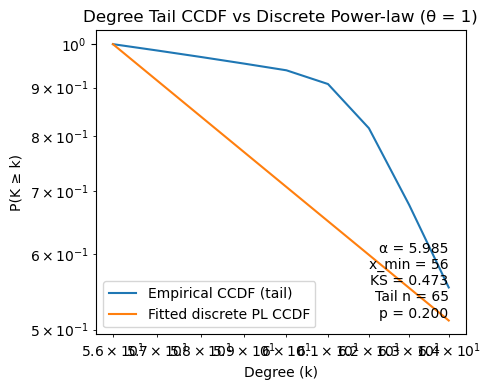

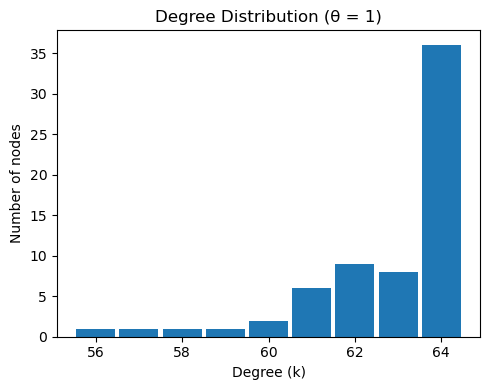

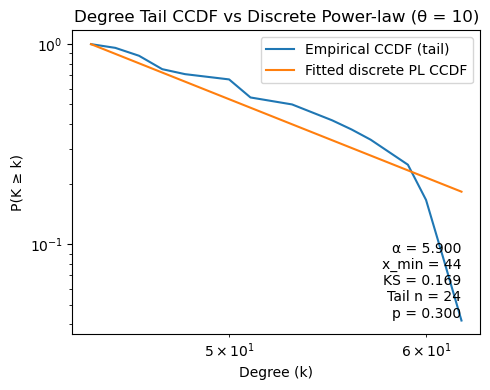

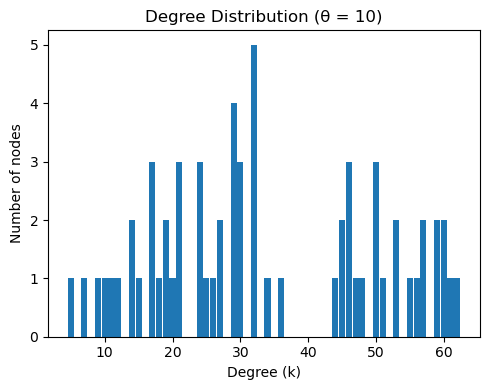

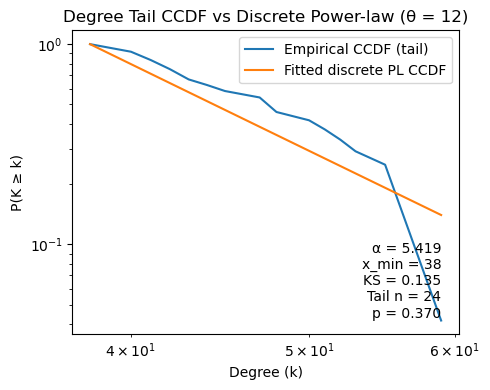

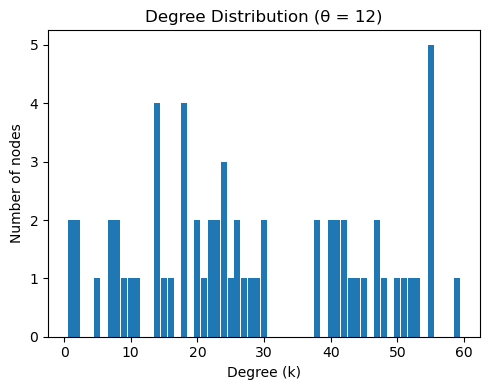

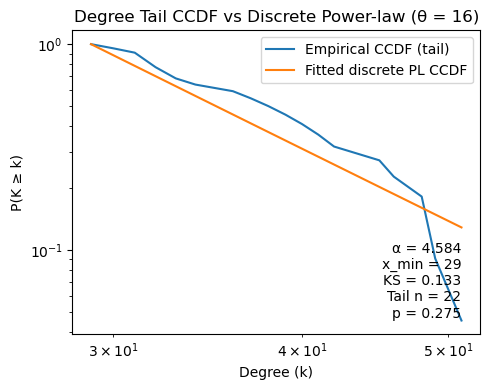

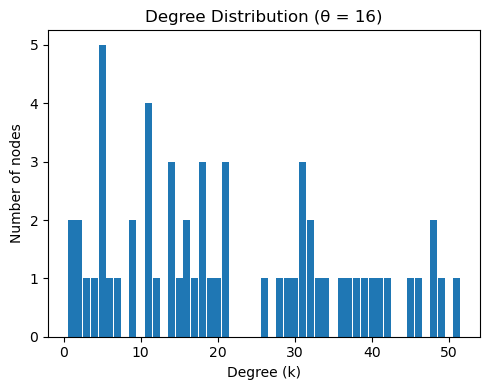

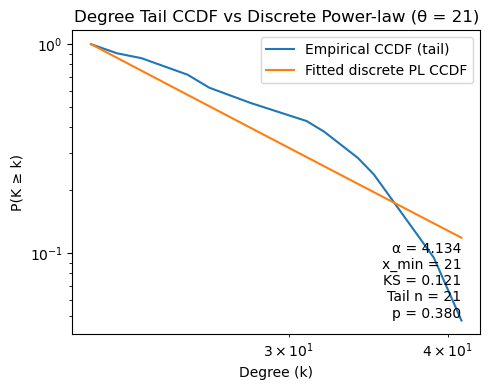

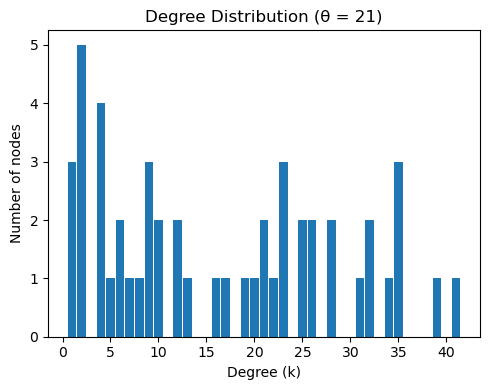

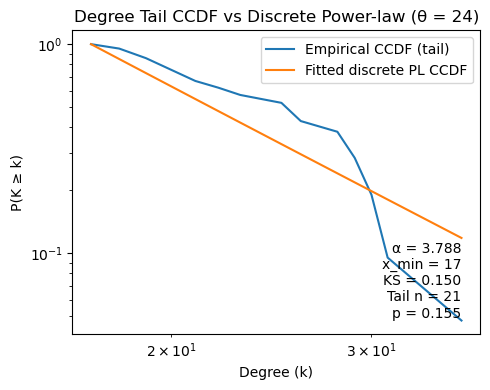

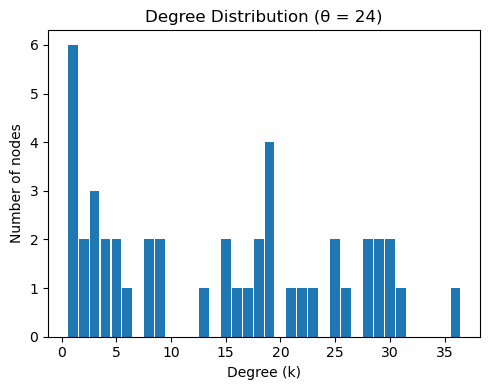

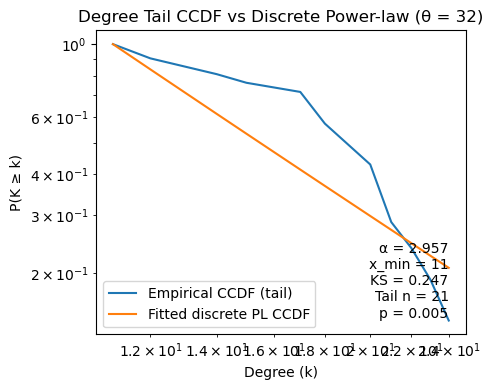

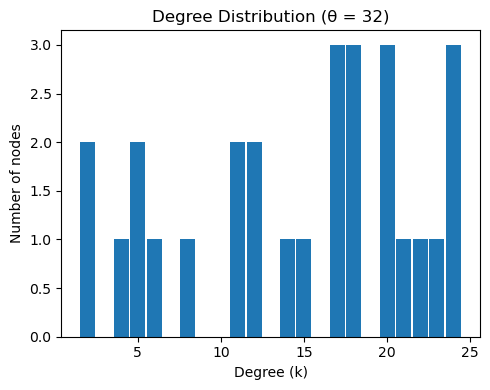

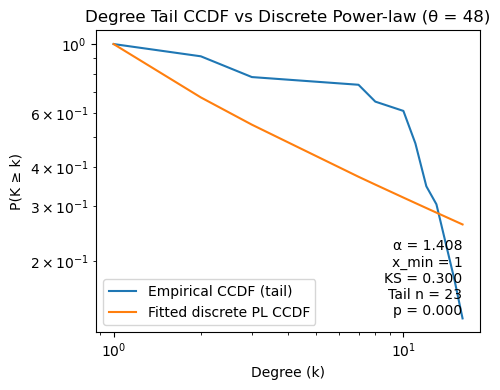

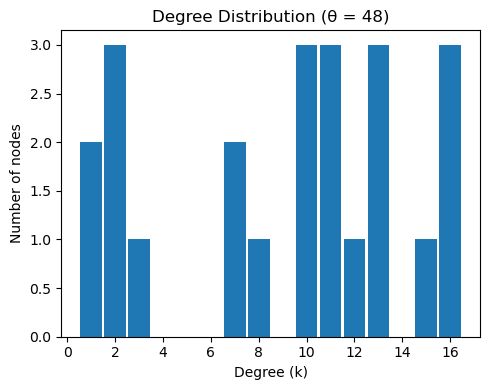

In [30]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import adjusted_rand_score as ARI
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import math
from functools import lru_cache

# Optional: exact Hurwitz zeta for discrete PL (preferred if available)
try:
    import mpmath as mp
    _HAS_MPMATH = True
    mp.mp.dps = 50  # precision
except Exception:
    _HAS_MPMATH = False
    print("[WARN] mpmath not found. Using fast discrete fallback (finite-sum + tail integral).")

# =========================
# CONFIG
# =========================
PERCENTILES = [0, 50, 60, 70, 80, 85, 90, 95]   # θ candidates from edge-weight percentiles
SHOW_PLOT = False                                # quick unthresholded visualization (optional)
TOP_K = 20                                       # for hub stability (degree ranks)
SEED = 42
EXPORT_CSV = None                                # e.g., "dd_species_threshold_eval.csv"

# --- plotting controls for power-law diagnostics ---
PLOT_POWERLAW = True            # make CCDF plots for every theta
SAVE_PLOTS = False              # set True to save PNGs
PLOT_DIR = "powerlaw_plots"     # output folder if SAVE_PLOTS=True

# --- goodness-of-fit Monte Carlo ---
GOF_MC_REPS = 200               # increase for more stable p-values (e.g., 1000)
RANDOM_STATE = np.random.RandomState(SEED)

# -------------------------------------------------------------------
# Expectation: You already have B_species defined in the environment:
#   - Bipartite graph with node attribute "bipartite" (0 = disease, 1 = taxa)
#   - Edges connect disease <-> taxon (species)
#   - disease_dict (optional) maps disease IDs -> readable names
# -------------------------------------------------------------------

# =========================
# 1) Build weighted disease–disease projection from bipartite B_species
# =========================
diseases = {n for n, d in B_species.nodes(data=True) if d.get("bipartite") == 0}
if not diseases:
    raise ValueError("No disease nodes found with bipartite==0 in B_species.")

# Weighted projection: edge 'weight' == number of shared taxa
G = bipartite.weighted_projected_graph(B_species, diseases)

# =========================
# 2) Descriptive summary (unthresholded)
# =========================
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (float(deg_vals.min()) if deg_vals.size else None,
                     float(deg_vals.max()) if deg_vals.size else None),
    "Edge weight range": (float(weights.min()) if weights.size else None,
                          float(weights.max()) if weights.size else None),
}
print("=== Network Summary (Unthresholded) ===")
for k, v in summary.items():
    print(f"{k}: {v}")

if weights.size == 0:
    raise ValueError("Graph G has no edges.")

# =========================
# (Optional) quick plot (unthresholded)
# =========================
if SHOW_PLOT:
    pos = nx.spring_layout(G, seed=SEED, k=1.2)
    dmin, dmax = deg_vals.min(), deg_vals.max()
    deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
    node_sizes = 200 + deg_norm * (1000 - 200)
    node_colors = cm.get_cmap("inferno")(deg_norm)
    wmin, wmax = weights.min(), weights.max()
    w_norm = (weights - wmin) / (wmax - wmin) if wmax != wmin else np.ones_like(weights)
    edge_widths = 1.0 + 4.0 * w_norm

    try:
        labels = {n: disease_dict.get(n, str(n)) for n in G.nodes()}
    except NameError:
        labels = {n: str(n) for n in G.nodes()}

    plt.figure(figsize=(18, 18))
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.45)
    nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()),
                           node_size=node_sizes, node_color=node_colors, alpha=0.95)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    plt.title("Disease–Disease Weighted Projection (size & color ~ degree)", fontsize=14)
    plt.axis("off")
    plt.show()

# =========================
# Helpers: community, stability, threshold summary
# =========================
def louvain_modularity(Gw, seed=SEED):
    # operate on non-isolates for meaningful communities
    nodes = [n for n, d in Gw.degree() if d > 0]
    if not nodes:
        return 0.0, {}
    sub = Gw.subgraph(nodes).copy()
    comms = nx.algorithms.community.louvain_communities(sub, seed=seed, weight="weight")
    Q = nx.algorithms.community.modularity(sub, comms, weight="weight")
    labmap = {}
    for cid, cset in enumerate(comms):
        for u in cset:
            labmap[u] = cid
    return Q, labmap

def topk_degree_ranks(Gw, k=TOP_K):
    deg = dict(Gw.degree())
    if not deg:
        return pd.Series(dtype=float)
    s = pd.Series(deg).sort_values(ascending=False)
    ranks = s.rank(method="dense", ascending=False)
    out = pd.Series(0.0, index=pd.Index(Gw.nodes()))
    out.loc[ranks.index] = ranks
    top_idx = ranks[ranks <= k].index
    out.loc[~out.index.isin(top_idx)] = 0.0
    return out

def spearman_between(r1: pd.Series, r2: pd.Series):
    if r1 is None or r2 is None:
        return np.nan
    idx = r1.index.union(r2.index)
    a = r1.reindex(idx, fill_value=0)
    b = r2.reindex(idx, fill_value=0)
    return a.corr(b, method="spearman")

def ari_between(labels1: dict, labels2: dict):
    if labels1 is None or labels2 is None:
        return np.nan
    idx = set(labels1).intersection(labels2)
    if len(idx) < 2:
        return np.nan
    y1 = [labels1[i] for i in idx]
    y2 = [labels2[i] for i in idx]
    return ARI(y1, y2)

def summarize_after_threshold(G_in: nx.Graph, theta):
    Gw = G_in.copy()
    Gw.remove_edges_from([(u, v) for u, v, d in Gw.edges(data=True)
                          if d.get("weight", 0.0) < theta])
    # remove isolates
    isolates = [n for n, d in Gw.degree() if d == 0]
    Gw.remove_nodes_from(isolates)

    n_nodes = Gw.number_of_nodes()
    n_edges = Gw.number_of_edges()

    if n_nodes > 0:
        comps = list(nx.connected_components(Gw))
        gc_frac = len(max(comps, key=len)) / n_nodes if comps else 0.0
        avg_degree = float(np.mean([deg for _, deg in Gw.degree()])) if n_nodes else 0.0
        density = nx.density(Gw) if n_nodes > 1 else 0.0
        n_components = nx.number_connected_components(Gw) if n_nodes else 0
    else:
        gc_frac, avg_degree, density, n_components = 0.0, 0.0, 0.0, 0

    Q, labels = louvain_modularity(Gw, seed=SEED)
    ranks = topk_degree_ranks(Gw, k=TOP_K)

    return Gw, {
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "avg_degree": avg_degree,
        "density": density,
        "n_components": n_components,
        "gc_frac": gc_frac,
        "modularity_Q": Q,
        "ranks": ranks,
        "labels": labels,
    }

# =========================
# Discrete power-law helpers (tail only)
# =========================
def _empirical_ccdf(data):
    """
    Return sorted unique integer x and empirical CCDF(x) for data array.
    CCDF at value v is P(X >= v).
    """
    x = np.sort(np.asarray(data, dtype=int))
    n = x.size
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=float)
    vals, counts = np.unique(x, return_counts=True)
    tail_counts = counts[::-1].cumsum()[::-1]
    ccdf = tail_counts / n
    return vals, ccdf

@lru_cache(maxsize=100000)
def _discrete_zeta_cached(alpha_x1000, xmin):
    """
    Cached helper for ζ(alpha, xmin) to speed up repeated calls.
    alpha_x1000 is int(alpha*1000) to make it hashable-stable for caching.
    """
    alpha = alpha_x1000 / 1000.0
    xmin = int(xmin)
    if _HAS_MPMATH:
        return float(mp.zeta(alpha, xmin))
    # Fallback: partial sum + integral tail
    K = 100000
    s = 0.0
    for k in range(xmin, xmin + K):
        s += k ** (-alpha)
    x0 = xmin + K - 0.5
    if alpha > 1:
        s += (x0 ** (1 - alpha)) / (alpha - 1)
    return s

def _discrete_zeta(alpha, xmin):
    # wrapper to use cache (quantize alpha to 3 decimals for speed)
    return _discrete_zeta_cached(int(round(float(alpha) * 1000)), int(xmin))

def _negloglik_discrete(alpha, data, xmin):
    """
    -log L for discrete PL: L ∝ ∏ [x_i^{-alpha} / ζ(alpha, xmin)]
    data must be >= xmin (integers).
    """
    alpha = float(alpha)
    if alpha <= 1.0:
        return np.inf

    data = np.asarray(data, dtype=int)
    if data.size == 0:
        return np.inf

    z = _discrete_zeta(alpha, int(xmin))
    if not np.isfinite(z) or z <= 0:
        return np.inf

    s_logx = float(np.sum(np.log(data)))
    return len(data) * math.log(z) + alpha * s_logx

def _mle_alpha_discrete(data, xmin):
    """
    Pure discrete MLE using Hurwitz zeta (or its fallback) via -logL minimization.
    Golden-section search on alpha ∈ [1.01, 6.0].
    """
    data = np.asarray(data, dtype=int)
    data = data[data >= int(xmin)]
    if data.size == 0:
        return np.nan

    # Golden-section search
    a_lo, a_hi = 1.01, 6.0

    def nll(a):
        return _negloglik_discrete(a, data, int(xmin))

    phi = (1 + 5 ** 0.5) / 2
    invphi = 1 / phi
    tol = 1e-7
    a, b = a_lo, a_hi
    c = b - invphi * (b - a)
    d = a + invphi * (b - a)
    fc = nll(c)
    fd = nll(d)

    it = 0
    while abs(b - a) > tol and it < 200:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi * (b - a)
            fc = nll(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi * (b - a)
            fd = nll(d)
        it += 1
    return (a + b) / 2.0

def fit_powerlaw_degree_tail_discrete(degrees, xmin_candidates="unique", adapt_tail=True,
                                      min_tail_n=20, tail_frac_floor=0.05, tail_n_cap=50):
    """
    Discrete power-law fit to the degree tail:
      - candidate xmin chosen from unique integer degree values
      - for each xmin, fit alpha by maximizing discrete likelihood with Hurwitz zeta
      - choose xmin minimizing KS distance between empirical CDF and model CDF
      - adaptive tail-size requirement keeps fitting stable at high θ

    Returns dict with pl_xmin, pl_alpha, pl_ks, pl_n_tail, pl_tail_prop
    """
    deg = np.asarray(list(degrees), dtype=int)
    deg = deg[np.isfinite(deg)]
    deg = deg[deg > 0]  # ignore zeros for tail
    if deg.size == 0:
        return {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.nan,
                "pl_n_tail": 0, "pl_tail_prop": 0.0}

    n_total = deg.size

    # candidate xmins
    if xmin_candidates == "unique":
        cands = np.unique(deg)
    else:
        cands = np.array(sorted({int(c) for c in xmin_candidates if c > 0}), dtype=int)
        if cands.size == 0:
            cands = np.unique(deg)

    # adaptive minimum tail size
    if adapt_tail:
        min_tail_n = max(10, min(tail_n_cap, int(max(min_tail_n, tail_frac_floor * n_total))))

    best = {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.inf,
            "pl_n_tail": 0, "pl_tail_prop": 0.0}

    for xmin in cands:
        tail = deg[deg >= xmin]
        n_tail = tail.size
        if n_tail < min_tail_n:
            continue

        alpha = _mle_alpha_discrete(tail, xmin)
        if not np.isfinite(alpha) or alpha <= 1.0:
            continue

        # Empirical CDF on tail support (integers)
        xs = np.sort(np.unique(tail))
        counts = np.array([(tail <= v).sum() for v in xs], dtype=float) / n_tail  # empirical CDF

        # Model CDF at integer x: F(x) = 1 - S(x+1)/S(xmin), where S(q) = ζ(alpha, q)
        denom = _discrete_zeta(alpha, xmin)
        S_xp1 = np.array([_discrete_zeta(alpha, int(v) + 1) for v in xs])
        F_pl = 1.0 - (S_xp1 / denom)

        ks = float(np.max(np.abs(counts - F_pl)))
        if ks < best["pl_ks"]:
            best.update({
                "pl_xmin": float(xmin),
                "pl_alpha": float(alpha),
                "pl_ks": float(ks),
                "pl_n_tail": int(n_tail),
                "pl_tail_prop": float(n_tail / n_total),
            })

    if not np.isfinite(best["pl_ks"]) or best["pl_ks"] == np.inf:
        return {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.nan,
                "pl_n_tail": 0, "pl_tail_prop": 0.0}

    return best

def discrete_ccdf_model(xs_int, xmin, alpha):
    """
    Model CCDF for discrete power-law at integer support xs_int (k >= xmin):
      CCDF(k) = P(X >= k) = ζ(alpha, k) / ζ(alpha, xmin)
    """
    xs_int = np.asarray(xs_int, dtype=int)
    denom = _discrete_zeta(alpha, int(xmin))
    num = np.array([_discrete_zeta(alpha, int(k)) for k in xs_int])
    return num / denom

def _cdf_discrete_pl(k, alpha, xmin):
    """F(k) for discrete PL at integer k (k >= xmin)."""
    denom = _discrete_zeta(alpha, int(xmin))
    return 1.0 - (_discrete_zeta(alpha, int(k) + 1) / denom)

def _sample_discrete_powerlaw(alpha, xmin, size, rng):
    """
    Inverse-CDF sampling by binary search on integer support [xmin, ∞):
    F(k) = 1 - ζ(alpha, k+1)/ζ(alpha, xmin). Works with Hurwitz zeta.
    """
    samples = np.empty(size, dtype=int)
    # upper bracket: start at observed xmin and expand until F(hi) ~ 1.0 for given u
    for i in range(size):
        u = rng.uniform()
        # find high bracket
        lo = int(xmin)
        hi = lo
        # exponentially expand hi until F(hi) >= u
        while _cdf_discrete_pl(hi, alpha, xmin) < u:
            hi *= 2
            if hi > 10**7:  # emergency cap
                break
        # binary search in [lo, hi]
        while lo < hi:
            mid = (lo + hi) // 2
            if _cdf_discrete_pl(mid, alpha, xmin) >= u:
                hi = mid
            else:
                lo = mid + 1
        samples[i] = lo
    return samples

def ks_stat_empirical_vs_model_tail(tail, alpha, xmin):
    """KS distance between empirical CDF of tail and fitted discrete PL CDF at integer support."""
    tail = np.asarray(tail, dtype=int)
    n = tail.size
    xs = np.sort(np.unique(tail))
    empF = np.array([(tail <= v).sum() for v in xs], dtype=float) / n
    modF = np.array([_cdf_discrete_pl(int(v), alpha, int(xmin)) for v in xs], dtype=float)
    return float(np.max(np.abs(empF - modF)))

def gof_pvalue_discrete_pl_refit(tail, reps=GOF_MC_REPS, rng=RANDOM_STATE):
    """
    CSN-style GOF p-value for discrete PL:
      1) Fit (xmin_hat, alpha_hat) on the empirical tail.
      2) Compute KS_emp between empirical tail CDF and model CDF at (xmin_hat, alpha_hat).
      3) For each replicate:
         a) Simulate n samples from PL(alpha_hat, xmin_hat).
         b) Re-fit (xmin*, alpha*) to the synthetic data using the same procedure.
         c) Compute KS_sim between synthetic data and its own fitted model.
      4) p = mean(KS_sim >= KS_emp).
    """
    tail = np.asarray(tail, dtype=int)
    n = tail.size
    if n == 0:
        return np.nan

    # --- Fit on empirical tail ---
    fit_emp = fit_powerlaw_degree_tail_discrete(tail, xmin_candidates="unique", adapt_tail=True)
    xmin_hat, alpha_hat = fit_emp["pl_xmin"], fit_emp["pl_alpha"]
    if not (np.isfinite(xmin_hat) and np.isfinite(alpha_hat) and fit_emp["pl_n_tail"] > 0):
        return np.nan

    KS_emp = ks_stat_empirical_vs_model_tail(tail, alpha_hat, int(round(xmin_hat)))

    # --- Simulate + refit ---
    ks_sims = np.empty(int(reps), dtype=float)
    xmin_i = int(round(xmin_hat))
    for i in range(int(reps)):
        sim = _sample_discrete_powerlaw(alpha_hat, xmin_i, n, rng)
        fit_sim = fit_powerlaw_degree_tail_discrete(sim, xmin_candidates="unique", adapt_tail=True)
        xmins, alphas = fit_sim["pl_xmin"], fit_sim["pl_alpha"]
        if not (np.isfinite(xmins) and np.isfinite(alphas) and fit_sim["pl_n_tail"] > 0):
            ks_sims[i] = np.nan
            continue
        ks_sims[i] = ks_stat_empirical_vs_model_tail(sim, alphas, int(round(xmins)))

    ks_sims = ks_sims[np.isfinite(ks_sims)]
    if ks_sims.size == 0:
        return np.nan
    return float((ks_sims >= KS_emp).mean())

def plot_powerlaw_fit_for_theta(theta, deg_list, pl_dict):
    """
    Log-log plot of empirical degree CCDF (tail) and the fitted DISCRETE power-law CCDF.
    One figure per theta. Annotates alpha/xmin/KS/tail size (+ p-value if available).
    """
    xmin = pl_dict["pl_xmin"]
    alpha = pl_dict["pl_alpha"]
    ks = pl_dict["pl_ks"]
    n_tail = pl_dict["pl_n_tail"]
    pval = pl_dict.get("pl_p", np.nan)

    if not np.isfinite(xmin) or not np.isfinite(alpha) or n_tail == 0:
        print(f"[theta={theta}] No valid discrete power-law tail to plot.")
        return

    deg = np.asarray(deg_list, dtype=int)
    xmin_i = int(round(xmin))
    tail = deg[deg >= xmin_i]

    # empirical CCDF on tail
    xs_emp, ccdf_emp = _empirical_ccdf(tail)
    # model CCDF at same integer support
    ccdf_pl = discrete_ccdf_model(xs_emp, xmin_i, float(alpha))

    plt.figure(figsize=(5, 4))
    # Changed: dots → line for empirical CCDF
    plt.loglog(xs_emp, ccdf_emp, linestyle='-', color='tab:blue', label='Empirical CCDF (tail)')
    plt.loglog(xs_emp, ccdf_pl, linestyle='-', color='tab:orange', label='Fitted discrete PL CCDF')

    plt.xlabel("Degree (k)")
    plt.ylabel("P(K ≥ k)")
    plt.title(f"Degree Tail CCDF vs Discrete Power-law (θ = {theta})")

    txt = f"α = {alpha:.3f}\nx_min = {xmin_i}\nKS = {ks:.3f}\nTail n = {n_tail}"
    if np.isfinite(pval):
        txt += f"\np = {pval:.3f}"
    x_right = xs_emp.max()
    y_bottom = max(1e-6, float(min(ccdf_emp.min(), ccdf_pl.min())))
    plt.text(x_right, y_bottom, txt, ha='right', va='bottom')

    plt.legend()
    plt.tight_layout()

    if SAVE_PLOTS:
        os.makedirs(PLOT_DIR, exist_ok=True)
        out = os.path.join(PLOT_DIR, f"pl_ccdf_theta_{theta}.png")
        plt.savefig(out, dpi=200)
        print(f"Saved: {out}")

    plt.show()

# =========================
# 5) Percentile-based θ evaluation (with metrics + discrete power-law)
# =========================
integerish = np.allclose(weights, np.round(weights))
perc_vals_for_theta = np.percentile(weights, PERCENTILES)
thetas = [int(np.floor(v)) if integerish else float(v) for v in perc_vals_for_theta]
theta_unique = sorted(set(thetas))

theta_from_perc = {}
for p, v in zip(PERCENTILES, thetas):
    theta_from_perc.setdefault(v, p)

rows = []
prev_ranks = None
prev_labels = None
baseline_Q = None

# store deg lists and fit results for plotting later
theta_to_deg = {}
theta_to_pl = {}

for theta in theta_unique:
    Gw, stats = summarize_after_threshold(G, theta)

    # store baseline modularity at the first θ
    if baseline_Q is None:
        baseline_Q = stats["modularity_Q"]

    # ---- Discrete power-law fit on degree sequence of Gw (isolates removed already) ----
    deg_list = [d for _, d in Gw.degree()]
    pl = fit_powerlaw_degree_tail_discrete(
        deg_list,
        xmin_candidates="unique",
        adapt_tail=True,          # adapt to higher thresholds (smaller graphs)
        min_tail_n=20,            # baseline min tail size
        tail_frac_floor=0.05,     # at least 5% of degrees in tail if possible
        tail_n_cap=50             # cap required tail size
    )

    # add CSN-style Monte Carlo KS p-value with REFIT on each replicate
    if np.isfinite(pl["pl_xmin"]) and np.isfinite(pl["pl_alpha"]) and pl["pl_n_tail"] > 0:
        deg_arr = np.asarray(deg_list, dtype=int)
        tail = deg_arr[deg_arr >= int(round(pl["pl_xmin"]))]
        pl["pl_p"] = gof_pvalue_discrete_pl_refit(tail, reps=GOF_MC_REPS, rng=RANDOM_STATE)
    else:
        pl["pl_p"] = np.nan

    theta_to_deg[theta] = np.array(deg_list, dtype=int)
    theta_to_pl[theta] = pl

    # stability vs previous θ
    rho = spearman_between(prev_ranks, stats["ranks"]) if prev_ranks is not None else np.nan
    ari = ari_between(prev_labels, stats["labels"]) if prev_labels is not None else np.nan

    rows.append({
        "theta": theta,
        "non_isolate_frac": (stats["n_nodes"] / G.number_of_nodes()) if G.number_of_nodes() else 0.0,
        "gc_frac": stats["gc_frac"],
        "avg_degree": stats["avg_degree"],
        "density": stats["density"],
        "n_nodes": stats["n_nodes"],
        "n_edges": stats["n_edges"],
        "n_components": stats["n_components"],
        "modularity_Q": stats["modularity_Q"],
        "mod_gain_vs_baseline": stats["modularity_Q"] - baseline_Q,
        "spearman_topK_vs_prev": rho,
        "ARI_vs_prev": ari,
        # Power-law diagnostics (discrete)
        "pl_xmin": pl["pl_xmin"],
        "pl_alpha": pl["pl_alpha"],
        "pl_ks": pl["pl_ks"],
        "pl_n_tail": pl["pl_n_tail"],
        "pl_tail_prop": pl["pl_tail_prop"],
        "pl_p": pl["pl_p"],                       # CSN GOF p-value (refit)
        "from_percentile": theta_from_perc.get(theta, pd.NA),
    })

    prev_ranks = stats["ranks"]
    prev_labels = stats["labels"]

df_theta = pd.DataFrame(rows).sort_values("theta").reset_index(drop=True)

# Pretty table
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", "{:,.6f}".format)

print("\n=== Percentile → θ (edge-weight) Map ===")
for p, v in zip(PERCENTILES, perc_vals_for_theta):
    v_disp = int(np.floor(v)) if integerish else float(v)
    print(f"  {p:>3}th percentile → θ = {v_disp}")

print("\n=== Threshold Evaluation Table (keep edges with weight ≥ θ) ===")
print(df_theta.to_string(index=False))

if EXPORT_CSV:
    df_theta.to_csv(EXPORT_CSV, index=False)
    print(f"\nSaved: {EXPORT_CSV}")



# --- add near your plotting controls ---
PLOT_DEGREE_HIST = True        # make degree distribution bar plots for every theta

# =========================
# NEW: degree-distribution bar plot (per θ)
# =========================
def plot_degree_hist_for_theta(theta, deg_list):
    """
    Bar plot of degree (k) vs number of nodes with that degree, for a given θ.
    Works on the post-threshold graph's degree list (isolates already removed).
    """
    deg = np.asarray(deg_list, dtype=int)
    deg = deg[np.isfinite(deg)]
    if deg.size == 0:
        print(f"[theta={theta}] No degrees to plot.")
        return

    # counts per integer degree
    vals, counts = np.unique(deg, return_counts=True)

    plt.figure(figsize=(5, 4))
    plt.bar(vals, counts, width=0.9, align='center')
    plt.xlabel("Degree (k)")
    plt.ylabel("Number of nodes")
    plt.title(f"Degree Distribution (θ = {theta})")
    plt.tight_layout()

    if SAVE_PLOTS:
        os.makedirs(PLOT_DIR, exist_ok=True)
        out = os.path.join(PLOT_DIR, f"degree_hist_theta_{theta}.png")
        plt.savefig(out, dpi=200)
        print(f"Saved: {out}")

    plt.show()

# =========================
# (unchanged) plot_powerlaw_fit_for_theta(...) already defined above
# =========================

# =========================
# 6) Plot discrete power-law fits AND degree histograms for all thresholds
# =========================
if PLOT_POWERLAW or PLOT_DEGREE_HIST:
    for theta in theta_unique:
        deg_list = theta_to_deg[theta]
        if PLOT_POWERLAW:
            pl = theta_to_pl[theta]
            plot_powerlaw_fit_for_theta(theta, deg_list, pl)
        if PLOT_DEGREE_HIST:
            plot_degree_hist_for_theta(theta, deg_list)





=== Network Summary (Unthresholded) ===
Number of nodes: 65
Number of edges: 2041
Degree range: (np.float64(56.0), np.float64(64.0))
Edge weight range: (np.float64(1.0), np.float64(113.0))
Max possible edges: 2080



=== Percentile → θ Map ===
    0th percentile → θ = 1
   50th percentile → θ = 10
   60th percentile → θ = 12
   70th percentile → θ = 16
   80th percentile → θ = 21
   85th percentile → θ = 24
   90th percentile → θ = 32
   95th percentile → θ = 48

=== Threshold Evaluation Table (log-normal fit) ===
 theta  non_isolate_frac  gc_frac  avg_degree  density  n_nodes  n_edges  n_components  modularity_Q  mod_gain_vs_baseline  spearman_topK_vs_prev  ARI_vs_prev    ln_mu  ln_sigma    ln_ks  ln_n_tail  ln_tail_prop  from_percentile
     1          1.000000 1.000000   62.800000 0.981250       65     2041             1      0.098212              0.000000                    NaN          NaN 4.139529  0.029463 0.282837         65      1.000000                0
    10          0.984615 1.000000   33.750000 0.535714       64     1080             1      0.119386              0.021173              -0.543336     0.883855 3.374379  0.580468 0.119281         64      1.000000               50
    12   

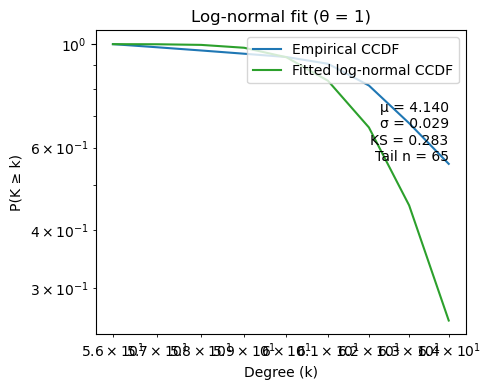

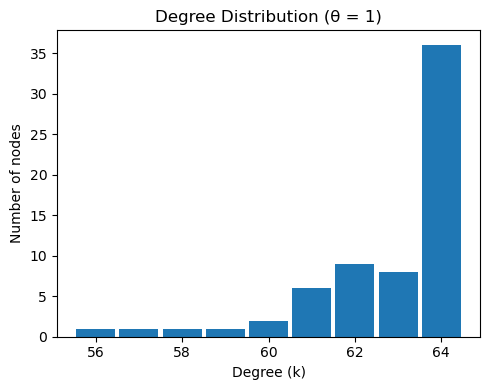

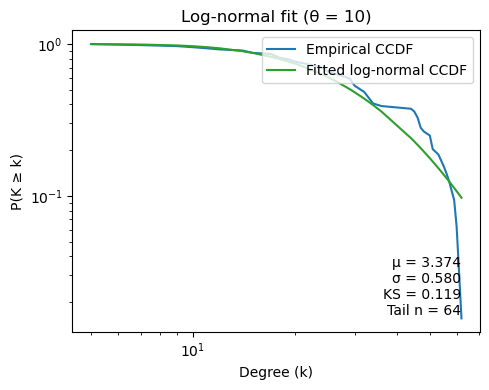

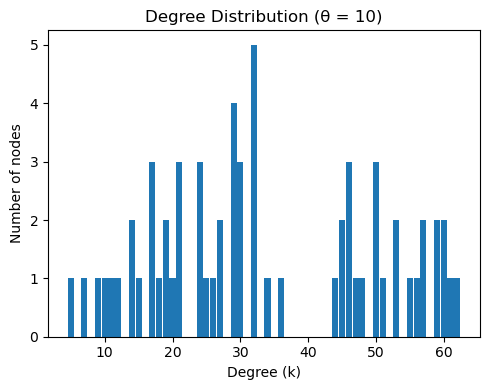

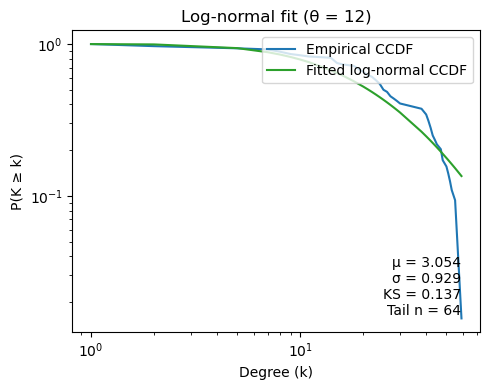

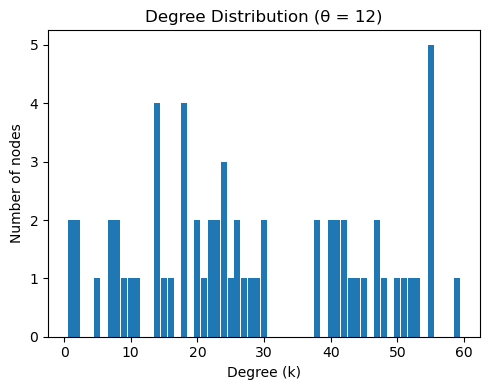

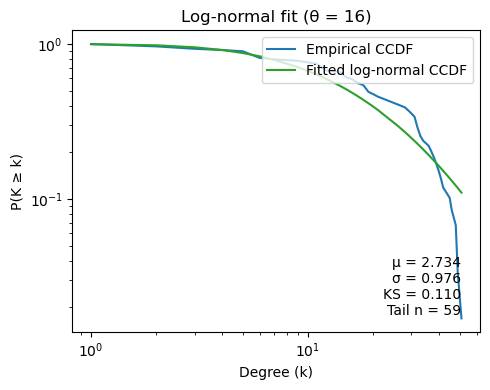

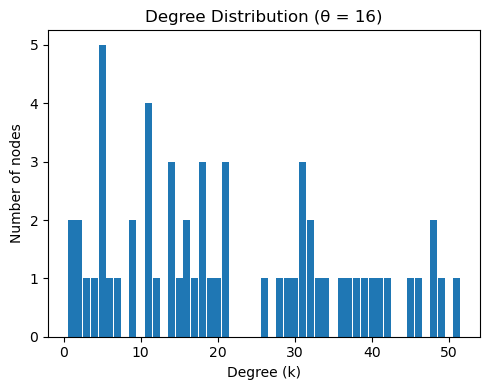

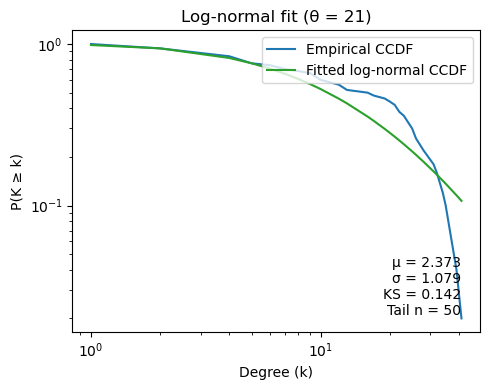

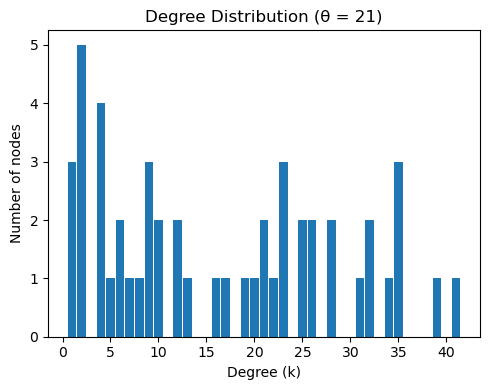

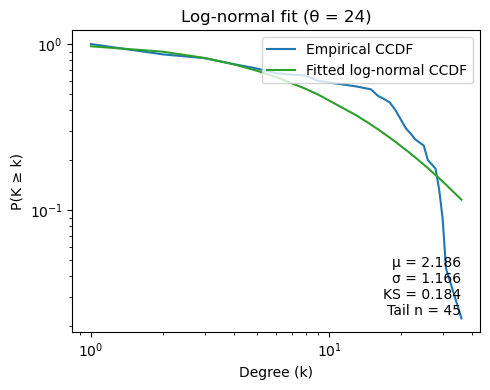

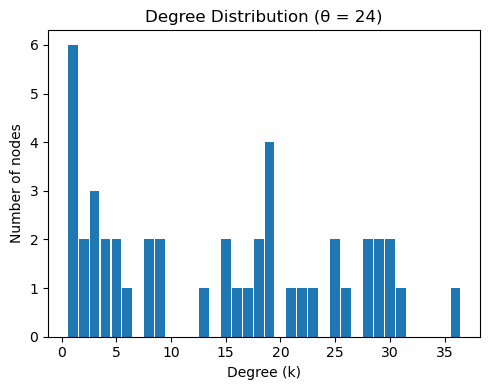

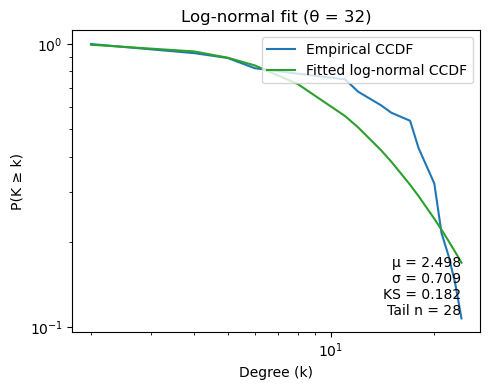

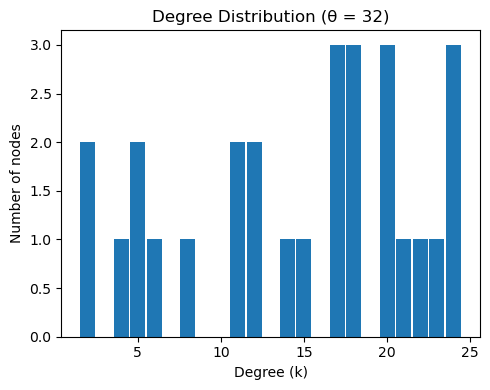

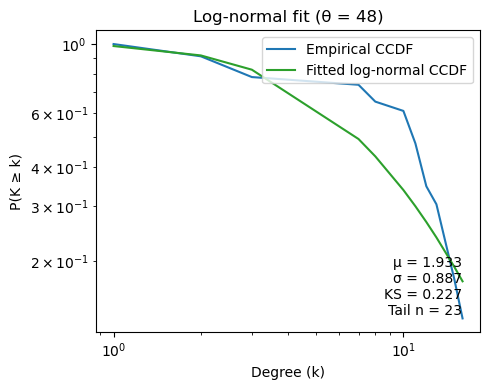

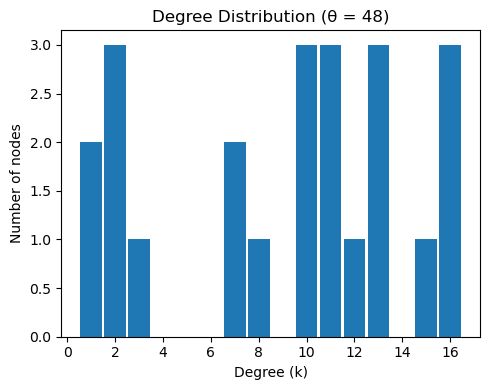

In [31]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import adjusted_rand_score as ARI
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import math
from functools import lru_cache
import scipy.stats as sps   # ✅ FIX: use sps instead of stats

# =========================
# CONFIG
# =========================
PERCENTILES = [0, 50, 60, 70, 80, 85, 90, 95]
SHOW_PLOT = False
TOP_K = 20
SEED = 42
EXPORT_CSV = None

PLOT_LOGNORMAL = True
PLOT_DEGREE_HIST = True
SAVE_PLOTS = False
PLOT_DIR = "distribution_plots"

# -------------------------------------------------------------------
# Expectation: You already have B_genus defined:
# bipartite graph with node attribute "bipartite" (0 = disease, 1 = taxa)
# -------------------------------------------------------------------

# =========================
# 1) Build weighted disease–disease projection
# =========================
diseases = {n for n, d in B_species.nodes(data=True) if d.get("bipartite") == 0}
if not diseases:
    raise ValueError("No disease nodes found with bipartite==0 in B_species.")

G = bipartite.weighted_projected_graph(B_species, diseases)

# =========================
# Summary (unthresholded)
# =========================
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (deg_vals.min(), deg_vals.max()) if deg_vals.size else None,
    "Edge weight range": (weights.min(), weights.max()) if weights.size else None,
    "Max possible edges": int(num_nodes * (num_nodes - 1) // 2),
}
print("=== Network Summary (Unthresholded) ===")
for k, v in summary.items():
    print(f"{k}: {v}")

if weights.size == 0:
    raise ValueError("Graph G has no edges.")

# =========================
# Helpers (community, stability, etc.)
# =========================
def louvain_modularity(Gw, seed=SEED):
    nodes = [n for n, d in Gw.degree() if d > 0]
    if not nodes:
        return 0.0, {}
    sub = Gw.subgraph(nodes).copy()
    comms = nx.algorithms.community.louvain_communities(sub, seed=seed, weight="weight")
    Q = nx.algorithms.community.modularity(sub, comms, weight="weight")
    labmap = {}
    for cid, cset in enumerate(comms):
        for u in cset:
            labmap[u] = cid
    return Q, labmap

def topk_degree_ranks(Gw, k=TOP_K):
    deg = dict(Gw.degree())
    if not deg:
        return pd.Series(dtype=float)
    s = pd.Series(deg).sort_values(ascending=False)
    ranks = s.rank(method="dense", ascending=False)
    out = pd.Series(0.0, index=pd.Index(Gw.nodes()))
    out.loc[ranks.index] = ranks
    top_idx = ranks[ranks <= k].index
    out.loc[~out.index.isin(top_idx)] = 0.0
    return out

def spearman_between(r1: pd.Series, r2: pd.Series):
    if r1 is None or r2 is None:
        return np.nan
    idx = r1.index.union(r2.index)
    a = r1.reindex(idx, fill_value=0)
    b = r2.reindex(idx, fill_value=0)
    return a.corr(b, method="spearman")

def ari_between(labels1: dict, labels2: dict):
    if labels1 is None or labels2 is None:
        return np.nan
    idx = set(labels1).intersection(labels2)
    if len(idx) < 2:
        return np.nan
    y1 = [labels1[i] for i in idx]
    y2 = [labels2[i] for i in idx]
    return ARI(y1, y2)

def summarize_after_threshold(G_in: nx.Graph, theta):
    Gw = G_in.copy()
    Gw.remove_edges_from([(u, v) for u, v, d in Gw.edges(data=True)
                          if d.get("weight", 0.0) < theta])
    isolates = [n for n, d in Gw.degree() if d == 0]
    Gw.remove_nodes_from(isolates)

    n_nodes = Gw.number_of_nodes()
    n_edges = Gw.number_of_edges()

    if n_nodes > 0:
        comps = list(nx.connected_components(Gw))
        gc_frac = len(max(comps, key=len)) / n_nodes if comps else 0.0
        avg_degree = float(np.mean([deg for _, deg in Gw.degree()])) if n_nodes else 0.0
        density = nx.density(Gw) if n_nodes > 1 else 0.0
        n_components = nx.number_connected_components(Gw) if n_nodes else 0
    else:
        gc_frac, avg_degree, density, n_components = 0.0, 0.0, 0.0, 0

    Q, labels = louvain_modularity(Gw, seed=SEED)
    ranks = topk_degree_ranks(Gw, k=TOP_K)

    return Gw, {
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "avg_degree": avg_degree,
        "density": density,
        "n_components": n_components,
        "gc_frac": gc_frac,
        "modularity_Q": Q,
        "ranks": ranks,
        "labels": labels,
    }

# =========================
# Empirical CCDF
# =========================
def _empirical_ccdf(data):
    x = np.sort(np.asarray(data, dtype=int))
    n = x.size
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=float)
    vals, counts = np.unique(x, return_counts=True)
    tail_counts = counts[::-1].cumsum()[::-1]
    ccdf = tail_counts / n
    return vals, ccdf

# =========================
# Log-normal fitting
# =========================
def fit_lognormal(degrees, xmin=1, min_tail_n=20):
    # ✅ FIX: always convert to numpy array
    degrees = np.asarray(degrees, dtype=float)

    deg = degrees[np.isfinite(degrees)]
    deg = deg[deg >= xmin]
    n = deg.size
    if n < min_tail_n:
        return {"ln_mu": np.nan, "ln_sigma": np.nan, "ln_ks": np.nan,
                "ln_n_tail": 0, "ln_tail_prop": 0.0}
    
    sigma, loc, scale = sps.lognorm.fit(deg, floc=0)
    mu = np.log(scale)
    
    xs = np.sort(deg)
    emp_cdf = np.arange(1, n+1) / n
    mod_cdf = sps.lognorm.cdf(xs, s=sigma, loc=loc, scale=scale)
    ks = np.max(np.abs(emp_cdf - mod_cdf))
    
    return {
        "ln_mu": float(mu),
        "ln_sigma": float(sigma),
        "ln_ks": float(ks),
        "ln_n_tail": int(n),
        "ln_tail_prop": float(n / degrees.size if degrees.size else 0.0),
    }

def plot_lognormal_fit(theta, deg_list, ln_dict):
    mu = ln_dict["ln_mu"]
    sigma = ln_dict["ln_sigma"]
    ks = ln_dict["ln_ks"]
    n_tail = ln_dict["ln_n_tail"]

    if not np.isfinite(mu) or not np.isfinite(sigma) or n_tail == 0:
        print(f"[theta={theta}] No valid log-normal fit.")
        return
    
    deg = np.asarray(deg_list, dtype=float)
    deg = deg[deg > 0]

    xs_emp, ccdf_emp = _empirical_ccdf(deg)
    ccdf_ln = 1.0 - sps.lognorm.cdf(xs_emp, s=sigma, scale=np.exp(mu))

    plt.figure(figsize=(5, 4))
    plt.loglog(xs_emp, ccdf_emp, '-', color='tab:blue', label='Empirical CCDF')
    plt.loglog(xs_emp, ccdf_ln, '-', color='tab:green', label='Fitted log-normal CCDF')

    plt.xlabel("Degree (k)")
    plt.ylabel("P(K ≥ k)")
    plt.title(f"Log-normal fit (θ = {theta})")

    txt = f"μ = {mu:.3f}\nσ = {sigma:.3f}\nKS = {ks:.3f}\nTail n = {n_tail}"
    plt.text(xs_emp.max(), max(1e-6, ccdf_emp.min()), txt,
             ha='right', va='bottom')

    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# =========================
# Degree histogram
# =========================
def plot_degree_hist_for_theta(theta, deg_list):
    deg = np.asarray(deg_list, dtype=int)
    deg = deg[np.isfinite(deg)]
    if deg.size == 0:
        print(f"[theta={theta}] No degrees to plot.")
        return
    vals, counts = np.unique(deg, return_counts=True)
    plt.figure(figsize=(5, 4))
    plt.bar(vals, counts, width=0.9)
    plt.xlabel("Degree (k)")
    plt.ylabel("Number of nodes")
    plt.title(f"Degree Distribution (θ = {theta})")
    plt.tight_layout()
    plt.show()

# =========================
# 5) Evaluate thresholds (log-normal fit)
# =========================
integerish = np.allclose(weights, np.round(weights))
perc_vals_for_theta = np.percentile(weights, PERCENTILES)
thetas = [int(np.floor(v)) if integerish else float(v) for v in perc_vals_for_theta]
theta_unique = sorted(set(thetas))

theta_from_perc = {v: p for p, v in zip(PERCENTILES, thetas)}

rows = []
theta_to_deg = {}
theta_to_ln = {}

prev_ranks = None
prev_labels = None
baseline_Q = None

for theta in theta_unique:
    Gw, stats = summarize_after_threshold(G, theta)
    if baseline_Q is None:
        baseline_Q = stats["modularity_Q"]

    deg_list = [d for _, d in Gw.degree()]
    theta_to_deg[theta] = np.array(deg_list, dtype=int)

    ln = fit_lognormal(deg_list, xmin=1, min_tail_n=20)
    theta_to_ln[theta] = ln

    rho = spearman_between(prev_ranks, stats["ranks"]) if prev_ranks is not None else np.nan
    ari = ari_between(prev_labels, stats["labels"]) if prev_labels is not None else np.nan

    rows.append({
        "theta": theta,
        "non_isolate_frac": (stats["n_nodes"] / G.number_of_nodes()) if G.number_of_nodes() else 0.0,
        "gc_frac": stats["gc_frac"],
        "avg_degree": stats["avg_degree"],
        "density": stats["density"],
        "n_nodes": stats["n_nodes"],
        "n_edges": stats["n_edges"],
        "n_components": stats["n_components"],
        "modularity_Q": stats["modularity_Q"],
        "mod_gain_vs_baseline": stats["modularity_Q"] - baseline_Q,
        "spearman_topK_vs_prev": rho,
        "ARI_vs_prev": ari,
        # Log-normal diagnostics
        "ln_mu": ln["ln_mu"],
        "ln_sigma": ln["ln_sigma"],
        "ln_ks": ln["ln_ks"],
        "ln_n_tail": ln["ln_n_tail"],
        "ln_tail_prop": ln["ln_tail_prop"],
        "from_percentile": theta_from_perc.get(theta, pd.NA),
    })

    prev_ranks = stats["ranks"]
    prev_labels = stats["labels"]

df_theta = pd.DataFrame(rows).sort_values("theta").reset_index(drop=True)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", "{:,.6f}".format)

print("\n=== Percentile → θ Map ===")
for p, v in zip(PERCENTILES, perc_vals_for_theta):
    v_disp = int(np.floor(v)) if integerish else float(v)
    print(f"  {p:>3}th percentile → θ = {v_disp}")

print("\n=== Threshold Evaluation Table (log-normal fit) ===")
print(df_theta.to_string(index=False))

if EXPORT_CSV:
    df_theta.to_csv(EXPORT_CSV, index=False)
    print(f"\nSaved: {EXPORT_CSV}")

# =========================
# 6) Plots
# =========================
for theta in theta_unique:
    deg_list = theta_to_deg[theta]
    if PLOT_LOGNORMAL:
        plot_lognormal_fit(theta, deg_list, theta_to_ln[theta])
    if PLOT_DEGREE_HIST:
        plot_degree_hist_for_theta(theta, deg_list)


=== Network Summary (Unthresholded) ===
Number of nodes: 65
Number of edges: 2041
Degree range: (56.0, 64.0)
Edge weight range: (1.0, 113.0)

=== Percentile → θ (edge-weight) Map ===
    0th percentile → θ = 1
   50th percentile → θ = 10
   60th percentile → θ = 12
   70th percentile → θ = 16
   80th percentile → θ = 21
   85th percentile → θ = 24
   90th percentile → θ = 32
   95th percentile → θ = 48

=== Threshold Evaluation Table (keep edges with weight ≥ θ) ===
 theta  non_isolate_frac  gc_frac  avg_degree  density  n_nodes  n_edges  n_components  modularity_Q  mod_gain_vs_baseline  spearman_topK_vs_prev  ARI_vs_prev   pl_xmin  pl_alpha    pl_ks  pl_n_tail  pl_tail_prop     pl_p  from_percentile
     1          1.000000 1.000000   62.800000 0.981250       65     2041             1      0.098212              0.000000                    NaN          NaN 56.000000  5.984500 0.472815         65      1.000000 0.200000                0
    10          0.984615 1.000000   33.750000 0.535

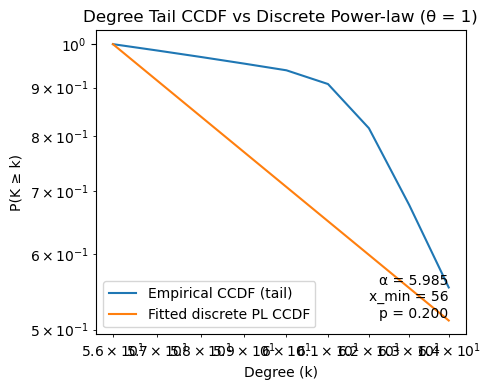

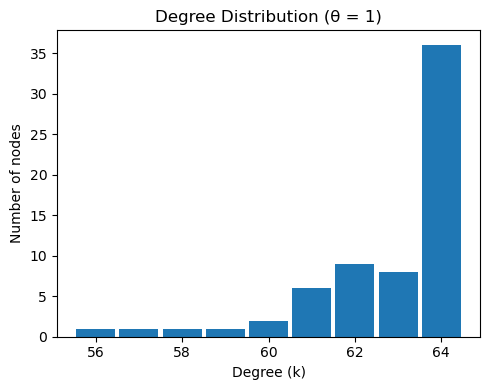

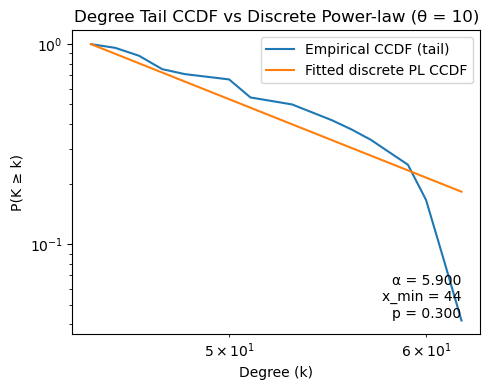

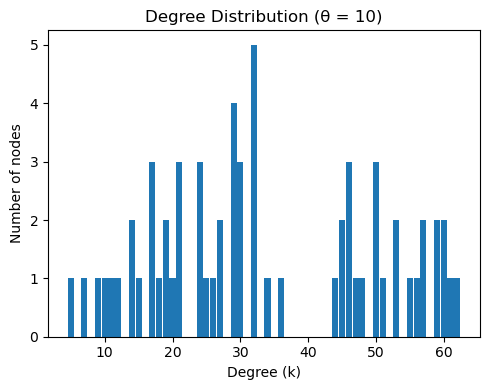

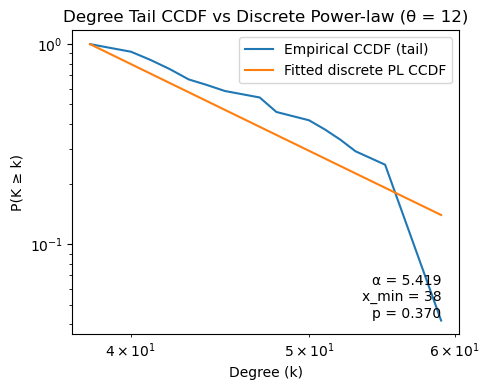

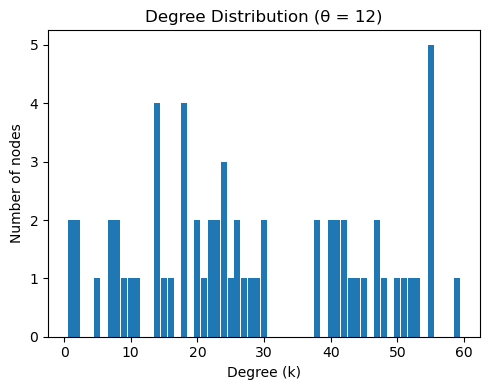

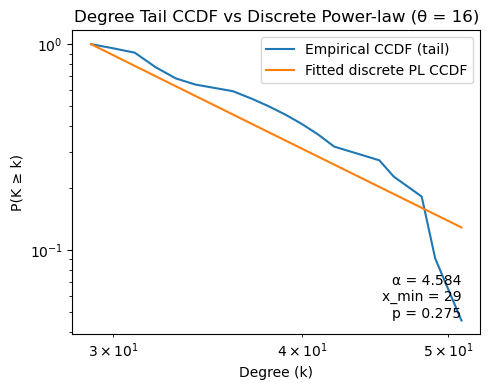

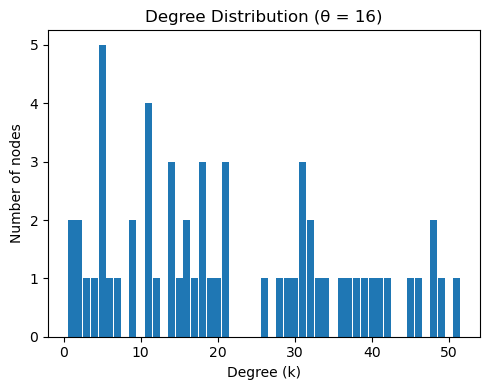

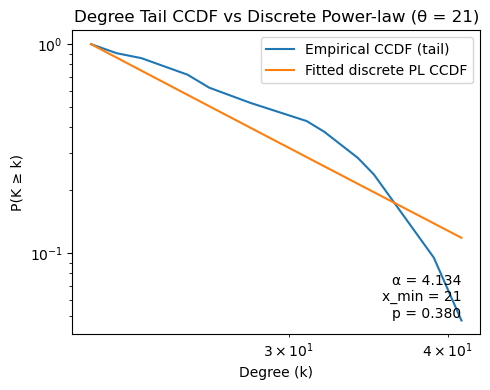

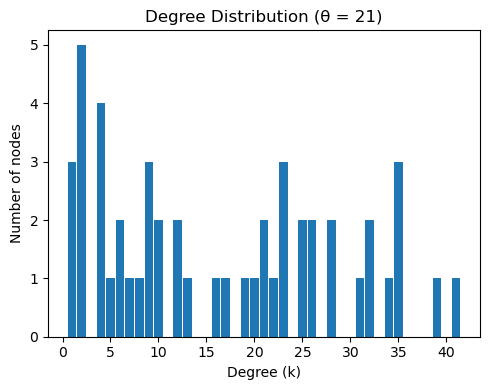

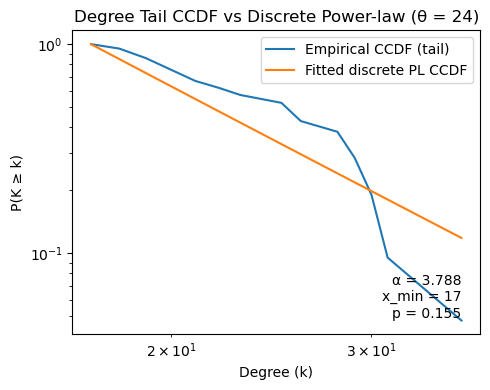

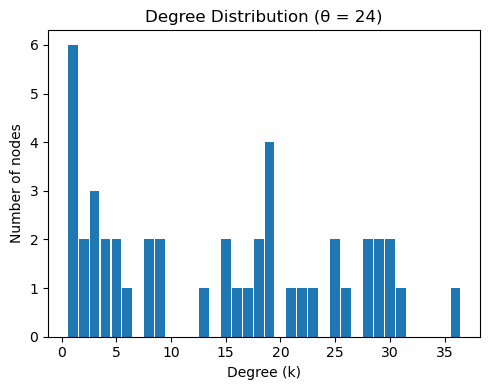

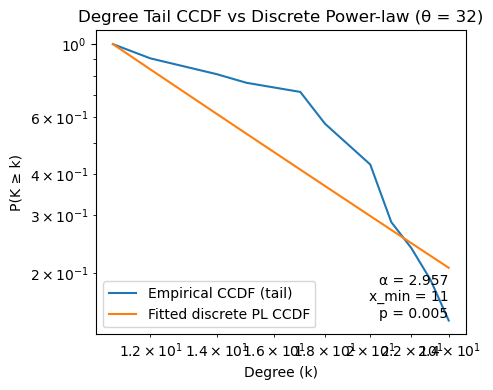

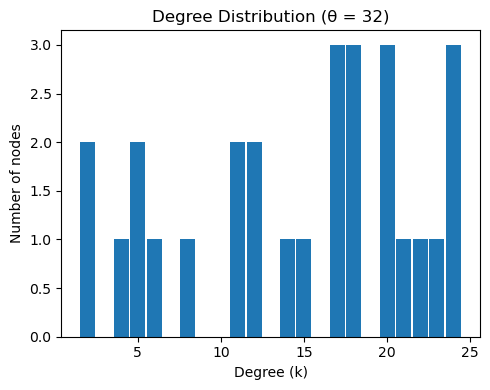

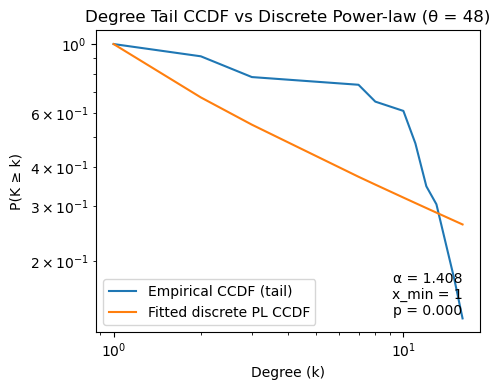

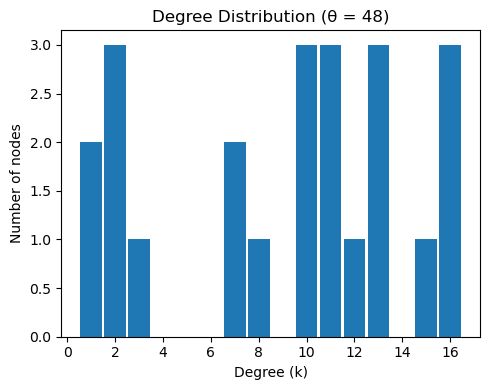

In [32]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import adjusted_rand_score as ARI
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import math
from functools import lru_cache

# Optional: exact Hurwitz zeta for discrete PL (preferred if available)
try:
    import mpmath as mp
    _HAS_MPMATH = True
    mp.mp.dps = 50  # precision
except Exception:
    _HAS_MPMATH = False
    print("[WARN] mpmath not found. Using fast discrete fallback (finite-sum + tail integral).")

# =========================
# CONFIG
# =========================
PERCENTILES = [0, 50, 60, 70, 80, 85, 90, 95]   # θ candidates from edge-weight percentiles
SHOW_PLOT = False                                # quick unthresholded visualization (optional)
TOP_K = 20                                       # for hub stability (degree ranks)
SEED = 42
EXPORT_CSV = None                                # e.g., "dd_species_threshold_eval.csv"

# --- plotting controls for power-law diagnostics ---
PLOT_POWERLAW = True            # make CCDF plots for every theta
SAVE_PLOTS = False              # set True to save PNGs
PLOT_DIR = "powerlaw_plots"     # output folder if SAVE_PLOTS=True

# --- goodness-of-fit Monte Carlo ---
GOF_MC_REPS = 200               # increase for more stable p-values (e.g., 1000)
RANDOM_STATE = np.random.RandomState(SEED)

# -------------------------------------------------------------------
# Expectation: You already have B_species defined in the environment:
#   - Bipartite graph with node attribute "bipartite" (0 = disease, 1 = taxa)
#   - Edges connect disease <-> taxon (species)
#   - disease_dict (optional) maps disease IDs -> readable names
# -------------------------------------------------------------------

# =========================
# 1) Build weighted disease–disease projection from bipartite B_species
# =========================
diseases = {n for n, d in B_species.nodes(data=True) if d.get("bipartite") == 0}
if not diseases:
    raise ValueError("No disease nodes found with bipartite==0 in B_species.")

# Weighted projection: edge 'weight' == number of shared taxa
G = bipartite.weighted_projected_graph(B_species, diseases)

# =========================
# 2) Descriptive summary (unthresholded)
# =========================
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (float(deg_vals.min()) if deg_vals.size else None,
                     float(deg_vals.max()) if deg_vals.size else None),
    "Edge weight range": (float(weights.min()) if weights.size else None,
                          float(weights.max()) if weights.size else None),
}
print("=== Network Summary (Unthresholded) ===")
for k, v in summary.items():
    print(f"{k}: {v}")

if weights.size == 0:
    raise ValueError("Graph G has no edges.")

# =========================
# (Optional) quick plot (unthresholded)
# =========================
if SHOW_PLOT:
    pos = nx.spring_layout(G, seed=SEED, k=1.2)
    dmin, dmax = deg_vals.min(), deg_vals.max()
    deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
    node_sizes = 200 + deg_norm * (1000 - 200)
    node_colors = cm.get_cmap("inferno")(deg_norm)
    wmin, wmax = weights.min(), weights.max()
    w_norm = (weights - wmin) / (wmax - wmin) if wmax != wmin else np.ones_like(weights)
    edge_widths = 1.0 + 4.0 * w_norm

    try:
        labels = {n: disease_dict.get(n, str(n)) for n in G.nodes()}
    except NameError:
        labels = {n: str(n) for n in G.nodes()}

    plt.figure(figsize=(18, 18))
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.45)
    nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()),
                           node_size=node_sizes, node_color=node_colors, alpha=0.95)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    plt.title("Disease–Disease Weighted Projection (size & color ~ degree)", fontsize=14)
    plt.axis("off")
    plt.show()

# =========================
# Helpers: community, stability, threshold summary
# =========================
def louvain_modularity(Gw, seed=SEED):
    # operate on non-isolates for meaningful communities
    nodes = [n for n, d in Gw.degree() if d > 0]
    if not nodes:
        return 0.0, {}
    sub = Gw.subgraph(nodes).copy()
    comms = nx.algorithms.community.louvain_communities(sub, seed=seed, weight="weight")
    Q = nx.algorithms.community.modularity(sub, comms, weight="weight")
    labmap = {}
    for cid, cset in enumerate(comms):
        for u in cset:
            labmap[u] = cid
    return Q, labmap

def topk_degree_ranks(Gw, k=TOP_K):
    deg = dict(Gw.degree())
    if not deg:
        return pd.Series(dtype=float)
    s = pd.Series(deg).sort_values(ascending=False)
    ranks = s.rank(method="dense", ascending=False)
    out = pd.Series(0.0, index=pd.Index(Gw.nodes()))
    out.loc[ranks.index] = ranks
    top_idx = ranks[ranks <= k].index
    out.loc[~out.index.isin(top_idx)] = 0.0
    return out

def spearman_between(r1: pd.Series, r2: pd.Series):
    if r1 is None or r2 is None:
        return np.nan
    idx = r1.index.union(r2.index)
    a = r1.reindex(idx, fill_value=0)
    b = r2.reindex(idx, fill_value=0)
    return a.corr(b, method="spearman")

def ari_between(labels1: dict, labels2: dict):
    if labels1 is None or labels2 is None:
        return np.nan
    idx = set(labels1).intersection(labels2)
    if len(idx) < 2:
        return np.nan
    y1 = [labels1[i] for i in idx]
    y2 = [labels2[i] for i in idx]
    return ARI(y1, y2)

def summarize_after_threshold(G_in: nx.Graph, theta):
    Gw = G_in.copy()
    Gw.remove_edges_from([(u, v) for u, v, d in Gw.edges(data=True)
                          if d.get("weight", 0.0) < theta])
    # remove isolates
    isolates = [n for n, d in Gw.degree() if d == 0]
    Gw.remove_nodes_from(isolates)

    n_nodes = Gw.number_of_nodes()
    n_edges = Gw.number_of_edges()

    if n_nodes > 0:
        comps = list(nx.connected_components(Gw))
        gc_frac = len(max(comps, key=len)) / n_nodes if comps else 0.0
        avg_degree = float(np.mean([deg for _, deg in Gw.degree()])) if n_nodes else 0.0
        density = nx.density(Gw) if n_nodes > 1 else 0.0
        n_components = nx.number_connected_components(Gw) if n_nodes else 0
    else:
        gc_frac, avg_degree, density, n_components = 0.0, 0.0, 0.0, 0

    Q, labels = louvain_modularity(Gw, seed=SEED)
    ranks = topk_degree_ranks(Gw, k=TOP_K)

    return Gw, {
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "avg_degree": avg_degree,
        "density": density,
        "n_components": n_components,
        "gc_frac": gc_frac,
        "modularity_Q": Q,
        "ranks": ranks,
        "labels": labels,
    }

# =========================
# Discrete power-law helpers (tail only)
# =========================
def _empirical_ccdf(data):
    """
    Return sorted unique integer x and empirical CCDF(x) for data array.
    CCDF at value v is P(X >= v).
    """
    x = np.sort(np.asarray(data, dtype=int))
    n = x.size
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=float)
    vals, counts = np.unique(x, return_counts=True)
    tail_counts = counts[::-1].cumsum()[::-1]
    ccdf = tail_counts / n
    return vals, ccdf

@lru_cache(maxsize=100000)
def _discrete_zeta_cached(alpha_x1000, xmin):
    """
    Cached helper for ζ(alpha, xmin) to speed up repeated calls.
    alpha_x1000 is int(alpha*1000) to make it hashable-stable for caching.
    """
    alpha = alpha_x1000 / 1000.0
    xmin = int(xmin)
    if _HAS_MPMATH:
        return float(mp.zeta(alpha, xmin))
    # Fallback: partial sum + integral tail
    K = 100000
    s = 0.0
    for k in range(xmin, xmin + K):
        s += k ** (-alpha)
    x0 = xmin + K - 0.5
    if alpha > 1:
        s += (x0 ** (1 - alpha)) / (alpha - 1)
    return s

def _discrete_zeta(alpha, xmin):
    # wrapper to use cache (quantize alpha to 3 decimals for speed)
    return _discrete_zeta_cached(int(round(float(alpha) * 1000)), int(xmin))

def _negloglik_discrete(alpha, data, xmin):
    """
    -log L for discrete PL: L ∝ ∏ [x_i^{-alpha} / ζ(alpha, xmin)]
    data must be >= xmin (integers).
    """
    alpha = float(alpha)
    if alpha <= 1.0:
        return np.inf

    data = np.asarray(data, dtype=int)
    if data.size == 0:
        return np.inf

    z = _discrete_zeta(alpha, int(xmin))
    if not np.isfinite(z) or z <= 0:
        return np.inf

    s_logx = float(np.sum(np.log(data)))
    return len(data) * math.log(z) + alpha * s_logx

def _mle_alpha_discrete(data, xmin):
    """
    Pure discrete MLE using Hurwitz zeta (or its fallback) via -logL minimization.
    Golden-section search on alpha ∈ [1.01, 6.0].
    """
    data = np.asarray(data, dtype=int)
    data = data[data >= int(xmin)]
    if data.size == 0:
        return np.nan

    # Golden-section search
    a_lo, a_hi = 1.01, 6.0

    def nll(a):
        return _negloglik_discrete(a, data, int(xmin))

    phi = (1 + 5 ** 0.5) / 2
    invphi = 1 / phi
    tol = 1e-7
    a, b = a_lo, a_hi
    c = b - invphi * (b - a)
    d = a + invphi * (b - a)
    fc = nll(c)
    fd = nll(d)

    it = 0
    while abs(b - a) > tol and it < 200:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi * (b - a)
            fc = nll(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi * (b - a)
            fd = nll(d)
        it += 1
    return (a + b) / 2.0

def fit_powerlaw_degree_tail_discrete(degrees, xmin_candidates="unique", adapt_tail=True,
                                      min_tail_n=20, tail_frac_floor=0.05, tail_n_cap=50):
    """
    Discrete power-law fit to the degree tail:
      - candidate xmin chosen from unique integer degree values
      - for each xmin, fit alpha by maximizing discrete likelihood with Hurwitz zeta
      - choose xmin minimizing KS distance between empirical CDF and model CDF
      - adaptive tail-size requirement keeps fitting stable at high θ

    Returns dict with pl_xmin, pl_alpha, pl_ks, pl_n_tail, pl_tail_prop
    """
    deg = np.asarray(list(degrees), dtype=int)
    deg = deg[np.isfinite(deg)]
    deg = deg[deg > 0]  # ignore zeros for tail
    if deg.size == 0:
        return {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.nan,
                "pl_n_tail": 0, "pl_tail_prop": 0.0}

    n_total = deg.size

    # candidate xmins
    if xmin_candidates == "unique":
        cands = np.unique(deg)
    else:
        cands = np.array(sorted({int(c) for c in xmin_candidates if c > 0}), dtype=int)
        if cands.size == 0:
            cands = np.unique(deg)

    # adaptive minimum tail size
    if adapt_tail:
        min_tail_n = max(10, min(tail_n_cap, int(max(min_tail_n, tail_frac_floor * n_total))))

    best = {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.inf,
            "pl_n_tail": 0, "pl_tail_prop": 0.0}

    for xmin in cands:
        tail = deg[deg >= xmin]
        n_tail = tail.size
        if n_tail < min_tail_n:
            continue

        alpha = _mle_alpha_discrete(tail, xmin)
        if not np.isfinite(alpha) or alpha <= 1.0:
            continue

        # Empirical CDF on tail support (integers)
        xs = np.sort(np.unique(tail))
        counts = np.array([(tail <= v).sum() for v in xs], dtype=float) / n_tail  # empirical CDF

        # Model CDF at integer x: F(x) = 1 - S(x+1)/S(xmin), where S(q) = ζ(alpha, q)
        denom = _discrete_zeta(alpha, xmin)
        S_xp1 = np.array([_discrete_zeta(alpha, int(v) + 1) for v in xs])
        F_pl = 1.0 - (S_xp1 / denom)

        ks = float(np.max(np.abs(counts - F_pl)))
        if ks < best["pl_ks"]:
            best.update({
                "pl_xmin": float(xmin),
                "pl_alpha": float(alpha),
                "pl_ks": float(ks),
                "pl_n_tail": int(n_tail),
                "pl_tail_prop": float(n_tail / n_total),
            })

    if not np.isfinite(best["pl_ks"]) or best["pl_ks"] == np.inf:
        return {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.nan,
                "pl_n_tail": 0, "pl_tail_prop": 0.0}

    return best

def discrete_ccdf_model(xs_int, xmin, alpha):
    """
    Model CCDF for discrete power-law at integer support xs_int (k >= xmin):
      CCDF(k) = P(X >= k) = ζ(alpha, k) / ζ(alpha, xmin)
    """
    xs_int = np.asarray(xs_int, dtype=int)
    denom = _discrete_zeta(alpha, int(xmin))
    num = np.array([_discrete_zeta(alpha, int(k)) for k in xs_int])
    return num / denom

def _cdf_discrete_pl(k, alpha, xmin):
    """F(k) for discrete PL at integer k (k >= xmin)."""
    denom = _discrete_zeta(alpha, int(xmin))
    return 1.0 - (_discrete_zeta(alpha, int(k) + 1) / denom)

def _sample_discrete_powerlaw(alpha, xmin, size, rng):
    """
    Inverse-CDF sampling by binary search on integer support [xmin, ∞):
    F(k) = 1 - ζ(alpha, k+1)/ζ(alpha, xmin). Works with Hurwitz zeta.
    """
    samples = np.empty(size, dtype=int)
    # upper bracket: start at observed xmin and expand until F(hi) ~ 1.0 for given u
    for i in range(size):
        u = rng.uniform()
        # find high bracket
        lo = int(xmin)
        hi = lo
        # exponentially expand hi until F(hi) >= u
        while _cdf_discrete_pl(hi, alpha, xmin) < u:
            hi *= 2
            if hi > 10**7:  # emergency cap
                break
        # binary search in [lo, hi]
        while lo < hi:
            mid = (lo + hi) // 2
            if _cdf_discrete_pl(mid, alpha, xmin) >= u:
                hi = mid
            else:
                lo = mid + 1
        samples[i] = lo
    return samples

def ks_stat_empirical_vs_model_tail(tail, alpha, xmin):
    """KS distance between empirical CDF of tail and fitted discrete PL CDF at integer support."""
    tail = np.asarray(tail, dtype=int)
    n = tail.size
    xs = np.sort(np.unique(tail))
    empF = np.array([(tail <= v).sum() for v in xs], dtype=float) / n
    modF = np.array([_cdf_discrete_pl(int(v), alpha, int(xmin)) for v in xs], dtype=float)
    return float(np.max(np.abs(empF - modF)))

def gof_pvalue_discrete_pl_refit(tail, reps=GOF_MC_REPS, rng=RANDOM_STATE):
    """
    CSN-style GOF p-value for discrete PL:
      1) Fit (xmin_hat, alpha_hat) on the empirical tail.
      2) Compute KS_emp between empirical tail CDF and model CDF at (xmin_hat, alpha_hat).
      3) For each replicate:
         a) Simulate n samples from PL(alpha_hat, xmin_hat).
         b) Re-fit (xmin*, alpha*) to the synthetic data using the same procedure.
         c) Compute KS_sim between synthetic data and its own fitted model.
      4) p = mean(KS_sim >= KS_emp).
    """
    tail = np.asarray(tail, dtype=int)
    n = tail.size
    if n == 0:
        return np.nan

    # --- Fit on empirical tail ---
    fit_emp = fit_powerlaw_degree_tail_discrete(tail, xmin_candidates="unique", adapt_tail=True)
    xmin_hat, alpha_hat = fit_emp["pl_xmin"], fit_emp["pl_alpha"]
    if not (np.isfinite(xmin_hat) and np.isfinite(alpha_hat) and fit_emp["pl_n_tail"] > 0):
        return np.nan

    KS_emp = ks_stat_empirical_vs_model_tail(tail, alpha_hat, int(round(xmin_hat)))

    # --- Simulate + refit ---
    ks_sims = np.empty(int(reps), dtype=float)
    xmin_i = int(round(xmin_hat))
    for i in range(int(reps)):
        sim = _sample_discrete_powerlaw(alpha_hat, xmin_i, n, rng)
        fit_sim = fit_powerlaw_degree_tail_discrete(sim, xmin_candidates="unique", adapt_tail=True)
        xmins, alphas = fit_sim["pl_xmin"], fit_sim["pl_alpha"]
        if not (np.isfinite(xmins) and np.isfinite(alphas) and fit_sim["pl_n_tail"] > 0):
            ks_sims[i] = np.nan
            continue
        ks_sims[i] = ks_stat_empirical_vs_model_tail(sim, alphas, int(round(xmins)))

    ks_sims = ks_sims[np.isfinite(ks_sims)]
    if ks_sims.size == 0:
        return np.nan
    return float((ks_sims >= KS_emp).mean())

def plot_powerlaw_fit_for_theta(theta, deg_list, pl_dict):
    """
    Log-log plot of empirical degree CCDF (tail) and the fitted DISCRETE power-law CCDF.
    One figure per theta. Annotates ONLY alpha/xmin/p.
    """
    xmin = pl_dict["pl_xmin"]
    alpha = pl_dict["pl_alpha"]
    n_tail = pl_dict["pl_n_tail"]
    pval = pl_dict.get("pl_p", np.nan)

    if not np.isfinite(xmin) or not np.isfinite(alpha) or n_tail == 0:
        print(f"[theta={theta}] No valid discrete power-law tail to plot.")
        return

    deg = np.asarray(deg_list, dtype=int)
    xmin_i = int(round(xmin))
    tail = deg[deg >= xmin_i]

    # empirical CCDF on tail
    xs_emp, ccdf_emp = _empirical_ccdf(tail)
    # model CCDF at same integer support
    ccdf_pl = discrete_ccdf_model(xs_emp, xmin_i, float(alpha))

    plt.figure(figsize=(5, 4))
    plt.loglog(xs_emp, ccdf_emp, linestyle='-', label='Empirical CCDF (tail)')
    plt.loglog(xs_emp, ccdf_pl, linestyle='-', label='Fitted discrete PL CCDF')

    plt.xlabel("Degree (k)")
    plt.ylabel("P(K ≥ k)")
    plt.title(f"Degree Tail CCDF vs Discrete Power-law (θ = {theta})")

    # --- annotation: only alpha, xmin, p-value ---
    if np.isfinite(pval):
        txt = f"α = {alpha:.3f}\nx_min = {xmin_i}\np = {pval:.3f}"
    else:
        txt = f"α = {alpha:.3f}\nx_min = {xmin_i}\np = NA"

    x_right = xs_emp.max()
    y_bottom = max(1e-6, float(min(ccdf_emp.min(), ccdf_pl.min())))
    plt.text(x_right, y_bottom, txt, ha='right', va='bottom')

    plt.legend()
    plt.tight_layout()

    if SAVE_PLOTS:
        os.makedirs(PLOT_DIR, exist_ok=True)
        out = os.path.join(PLOT_DIR, f"pl_ccdf_theta_{theta}.png")
        plt.savefig(out, dpi=200)
        print(f"Saved: {out}")

    plt.show()


# =========================
# 5) Percentile-based θ evaluation (with metrics + discrete power-law)
# =========================
integerish = np.allclose(weights, np.round(weights))
perc_vals_for_theta = np.percentile(weights, PERCENTILES)
thetas = [int(np.floor(v)) if integerish else float(v) for v in perc_vals_for_theta]
theta_unique = sorted(set(thetas))

theta_from_perc = {}
for p, v in zip(PERCENTILES, thetas):
    theta_from_perc.setdefault(v, p)

rows = []
prev_ranks = None
prev_labels = None
baseline_Q = None

# store deg lists and fit results for plotting later
theta_to_deg = {}
theta_to_pl = {}

for theta in theta_unique:
    Gw, stats = summarize_after_threshold(G, theta)

    # store baseline modularity at the first θ
    if baseline_Q is None:
        baseline_Q = stats["modularity_Q"]

    # ---- Discrete power-law fit on degree sequence of Gw (isolates removed already) ----
    deg_list = [d for _, d in Gw.degree()]
    pl = fit_powerlaw_degree_tail_discrete(
        deg_list,
        xmin_candidates="unique",
        adapt_tail=True,          # adapt to higher thresholds (smaller graphs)
        min_tail_n=20,            # baseline min tail size
        tail_frac_floor=0.05,     # at least 5% of degrees in tail if possible
        tail_n_cap=50             # cap required tail size
    )

    # add CSN-style Monte Carlo KS p-value with REFIT on each replicate
    if np.isfinite(pl["pl_xmin"]) and np.isfinite(pl["pl_alpha"]) and pl["pl_n_tail"] > 0:
        deg_arr = np.asarray(deg_list, dtype=int)
        tail = deg_arr[deg_arr >= int(round(pl["pl_xmin"]))]
        pl["pl_p"] = gof_pvalue_discrete_pl_refit(tail, reps=GOF_MC_REPS, rng=RANDOM_STATE)
    else:
        pl["pl_p"] = np.nan

    theta_to_deg[theta] = np.array(deg_list, dtype=int)
    theta_to_pl[theta] = pl

    # stability vs previous θ
    rho = spearman_between(prev_ranks, stats["ranks"]) if prev_ranks is not None else np.nan
    ari = ari_between(prev_labels, stats["labels"]) if prev_labels is not None else np.nan

    rows.append({
        "theta": theta,
        "non_isolate_frac": (stats["n_nodes"] / G.number_of_nodes()) if G.number_of_nodes() else 0.0,
        "gc_frac": stats["gc_frac"],
        "avg_degree": stats["avg_degree"],
        "density": stats["density"],
        "n_nodes": stats["n_nodes"],
        "n_edges": stats["n_edges"],
        "n_components": stats["n_components"],
        "modularity_Q": stats["modularity_Q"],
        "mod_gain_vs_baseline": stats["modularity_Q"] - baseline_Q,
        "spearman_topK_vs_prev": rho,
        "ARI_vs_prev": ari,
        # Power-law diagnostics (discrete)
        "pl_xmin": pl["pl_xmin"],
        "pl_alpha": pl["pl_alpha"],
        "pl_ks": pl["pl_ks"],
        "pl_n_tail": pl["pl_n_tail"],
        "pl_tail_prop": pl["pl_tail_prop"],
        "pl_p": pl["pl_p"],                       # CSN GOF p-value (refit)
        "from_percentile": theta_from_perc.get(theta, pd.NA),
    })

    prev_ranks = stats["ranks"]
    prev_labels = stats["labels"]

df_theta = pd.DataFrame(rows).sort_values("theta").reset_index(drop=True)

# Pretty table
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", "{:,.6f}".format)

print("\n=== Percentile → θ (edge-weight) Map ===")
for p, v in zip(PERCENTILES, perc_vals_for_theta):
    v_disp = int(np.floor(v)) if integerish else float(v)
    print(f"  {p:>3}th percentile → θ = {v_disp}")

print("\n=== Threshold Evaluation Table (keep edges with weight ≥ θ) ===")
print(df_theta.to_string(index=False))

if EXPORT_CSV:
    df_theta.to_csv(EXPORT_CSV, index=False)
    print(f"\nSaved: {EXPORT_CSV}")



# --- add near your plotting controls ---
PLOT_DEGREE_HIST = True        # make degree distribution bar plots for every theta

# =========================
# NEW: degree-distribution bar plot (per θ)
# =========================
def plot_degree_hist_for_theta(theta, deg_list):
    """
    Bar plot of degree (k) vs number of nodes with that degree, for a given θ.
    Works on the post-threshold graph's degree list (isolates already removed).
    """
    deg = np.asarray(deg_list, dtype=int)
    deg = deg[np.isfinite(deg)]
    if deg.size == 0:
        print(f"[theta={theta}] No degrees to plot.")
        return

    # counts per integer degree
    vals, counts = np.unique(deg, return_counts=True)

    plt.figure(figsize=(5, 4))
    plt.bar(vals, counts, width=0.9, align='center')
    plt.xlabel("Degree (k)")
    plt.ylabel("Number of nodes")
    plt.title(f"Degree Distribution (θ = {theta})")
    plt.tight_layout()

    if SAVE_PLOTS:
        os.makedirs(PLOT_DIR, exist_ok=True)
        out = os.path.join(PLOT_DIR, f"degree_hist_theta_{theta}.png")
        plt.savefig(out, dpi=200)
        print(f"Saved: {out}")

    plt.show()

# =========================
# (unchanged) plot_powerlaw_fit_for_theta(...) already defined above
# =========================

# =========================
# 6) Plot discrete power-law fits AND degree histograms for all thresholds
# =========================
if PLOT_POWERLAW or PLOT_DEGREE_HIST:
    for theta in theta_unique:
        deg_list = theta_to_deg[theta]
        if PLOT_POWERLAW:
            pl = theta_to_pl[theta]
            plot_powerlaw_fit_for_theta(theta, deg_list, pl)
        if PLOT_DEGREE_HIST:
            plot_degree_hist_for_theta(theta, deg_list)





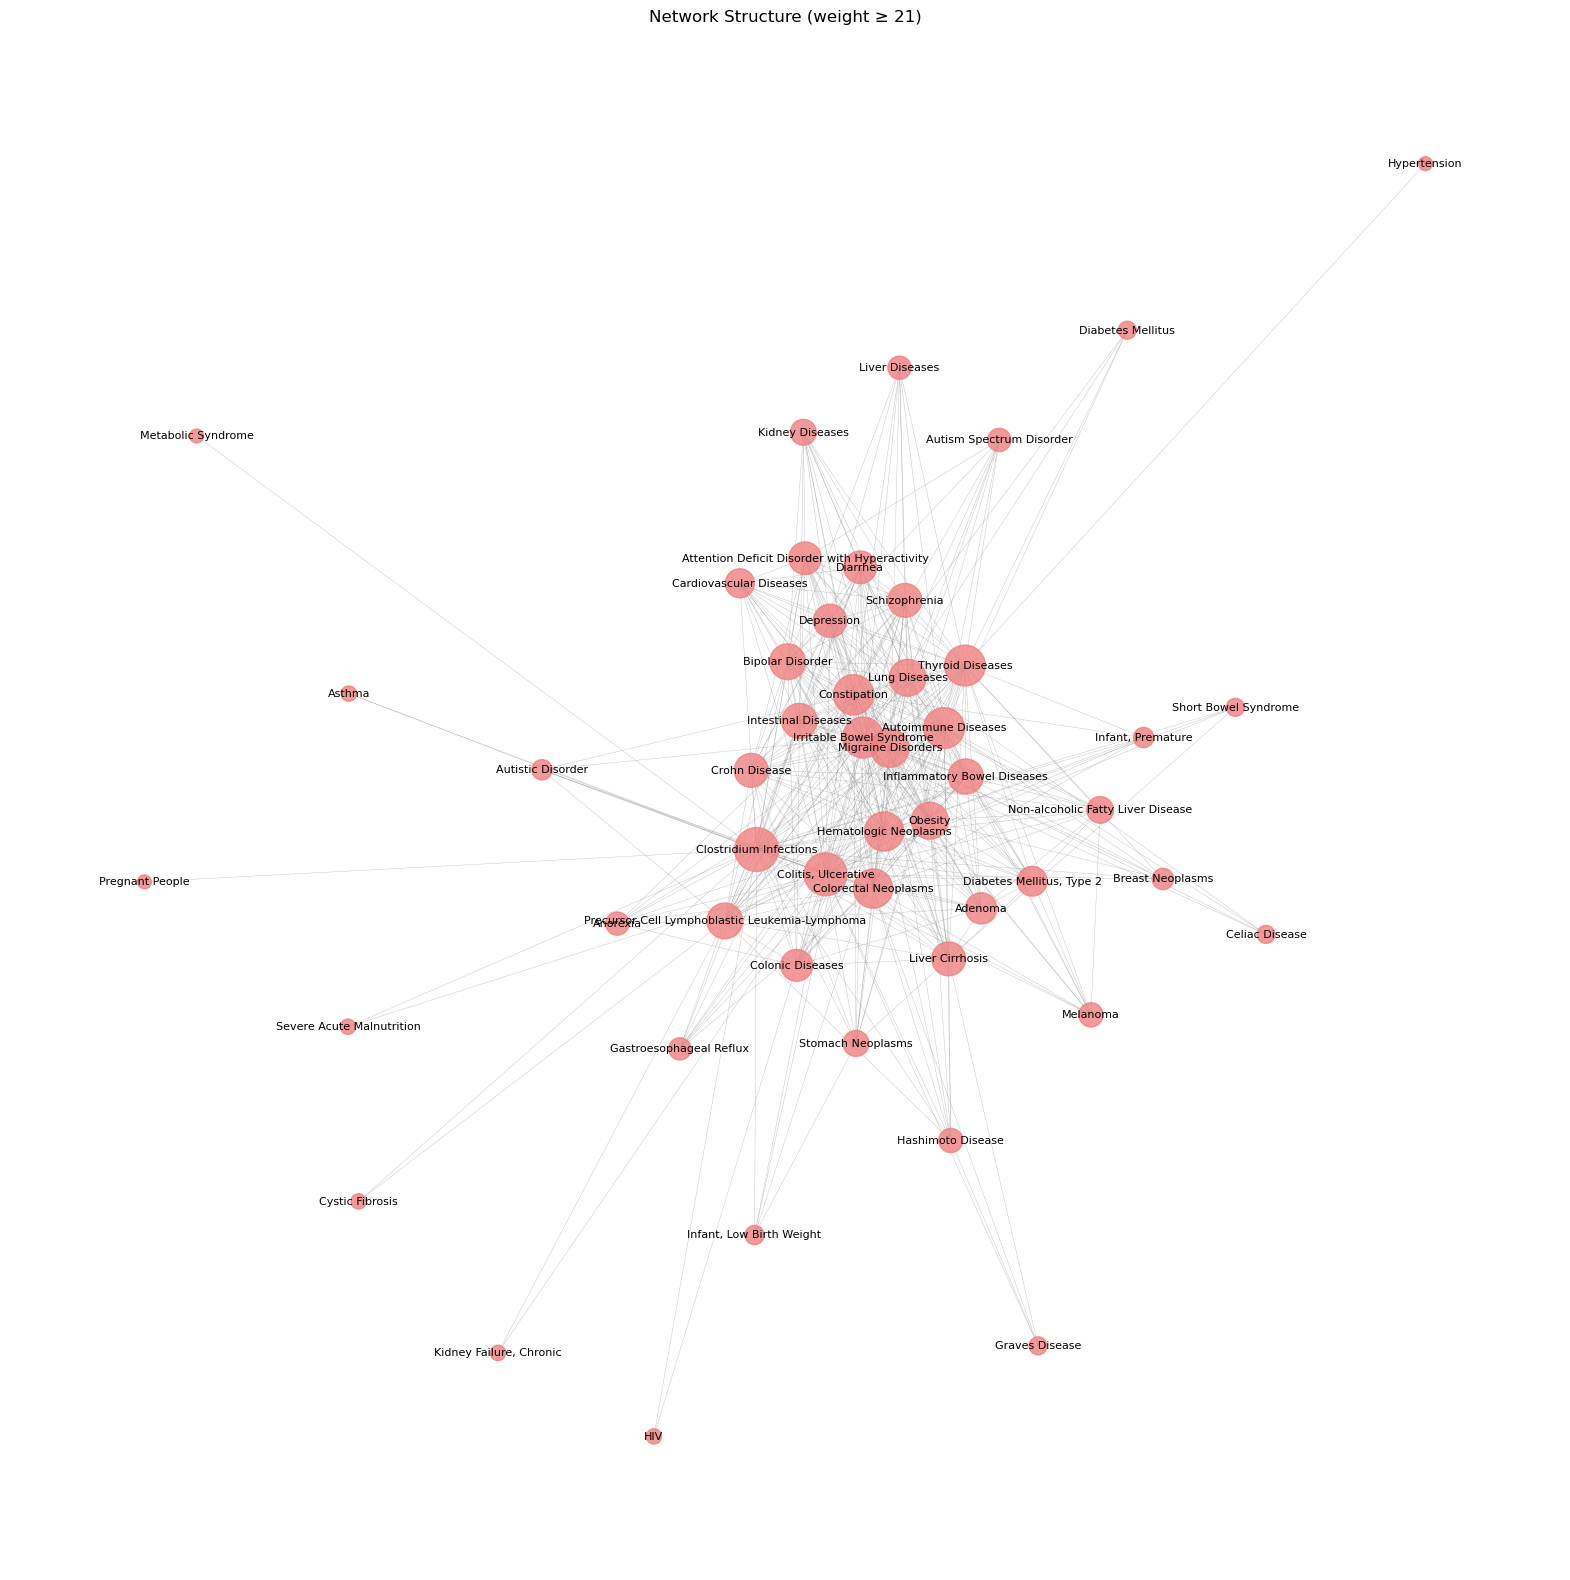

In [33]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# === User-defined threshold ===
edge_weight_threshold = 21 # change this to your cutoff

# === Step 1: Apply edge weight filtering ===
if edge_weight_threshold > 0:
    G_filtered = nx.Graph()
    for u, v, data in G.edges(data=True):
        weight = data.get("weight", 1)  # default weight = 1 if not present
        if weight >= edge_weight_threshold:
            G_filtered.add_edge(u, v, **data)
else:
    G_filtered = G.copy()

# If you don't already have pos from a previous cell, compute it here:
pos = nx.spring_layout(G_filtered, seed=42)

# Map node IDs to readable labels from disease_dict
labels = {n: disease_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Node sizes: normalize degree to [0,1] then map to pixel range ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)

min_size, max_size = 100, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Plot ---
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.8)
nx.draw_networkx_edges(G_filtered, pos, width=0.3, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=8)

plt.title(f"Network Structure (weight ≥ {edge_weight_threshold})")
plt.axis('off')
plt.show()


/tmp/slurm.4730828/ipykernel_3960228/2301618365.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


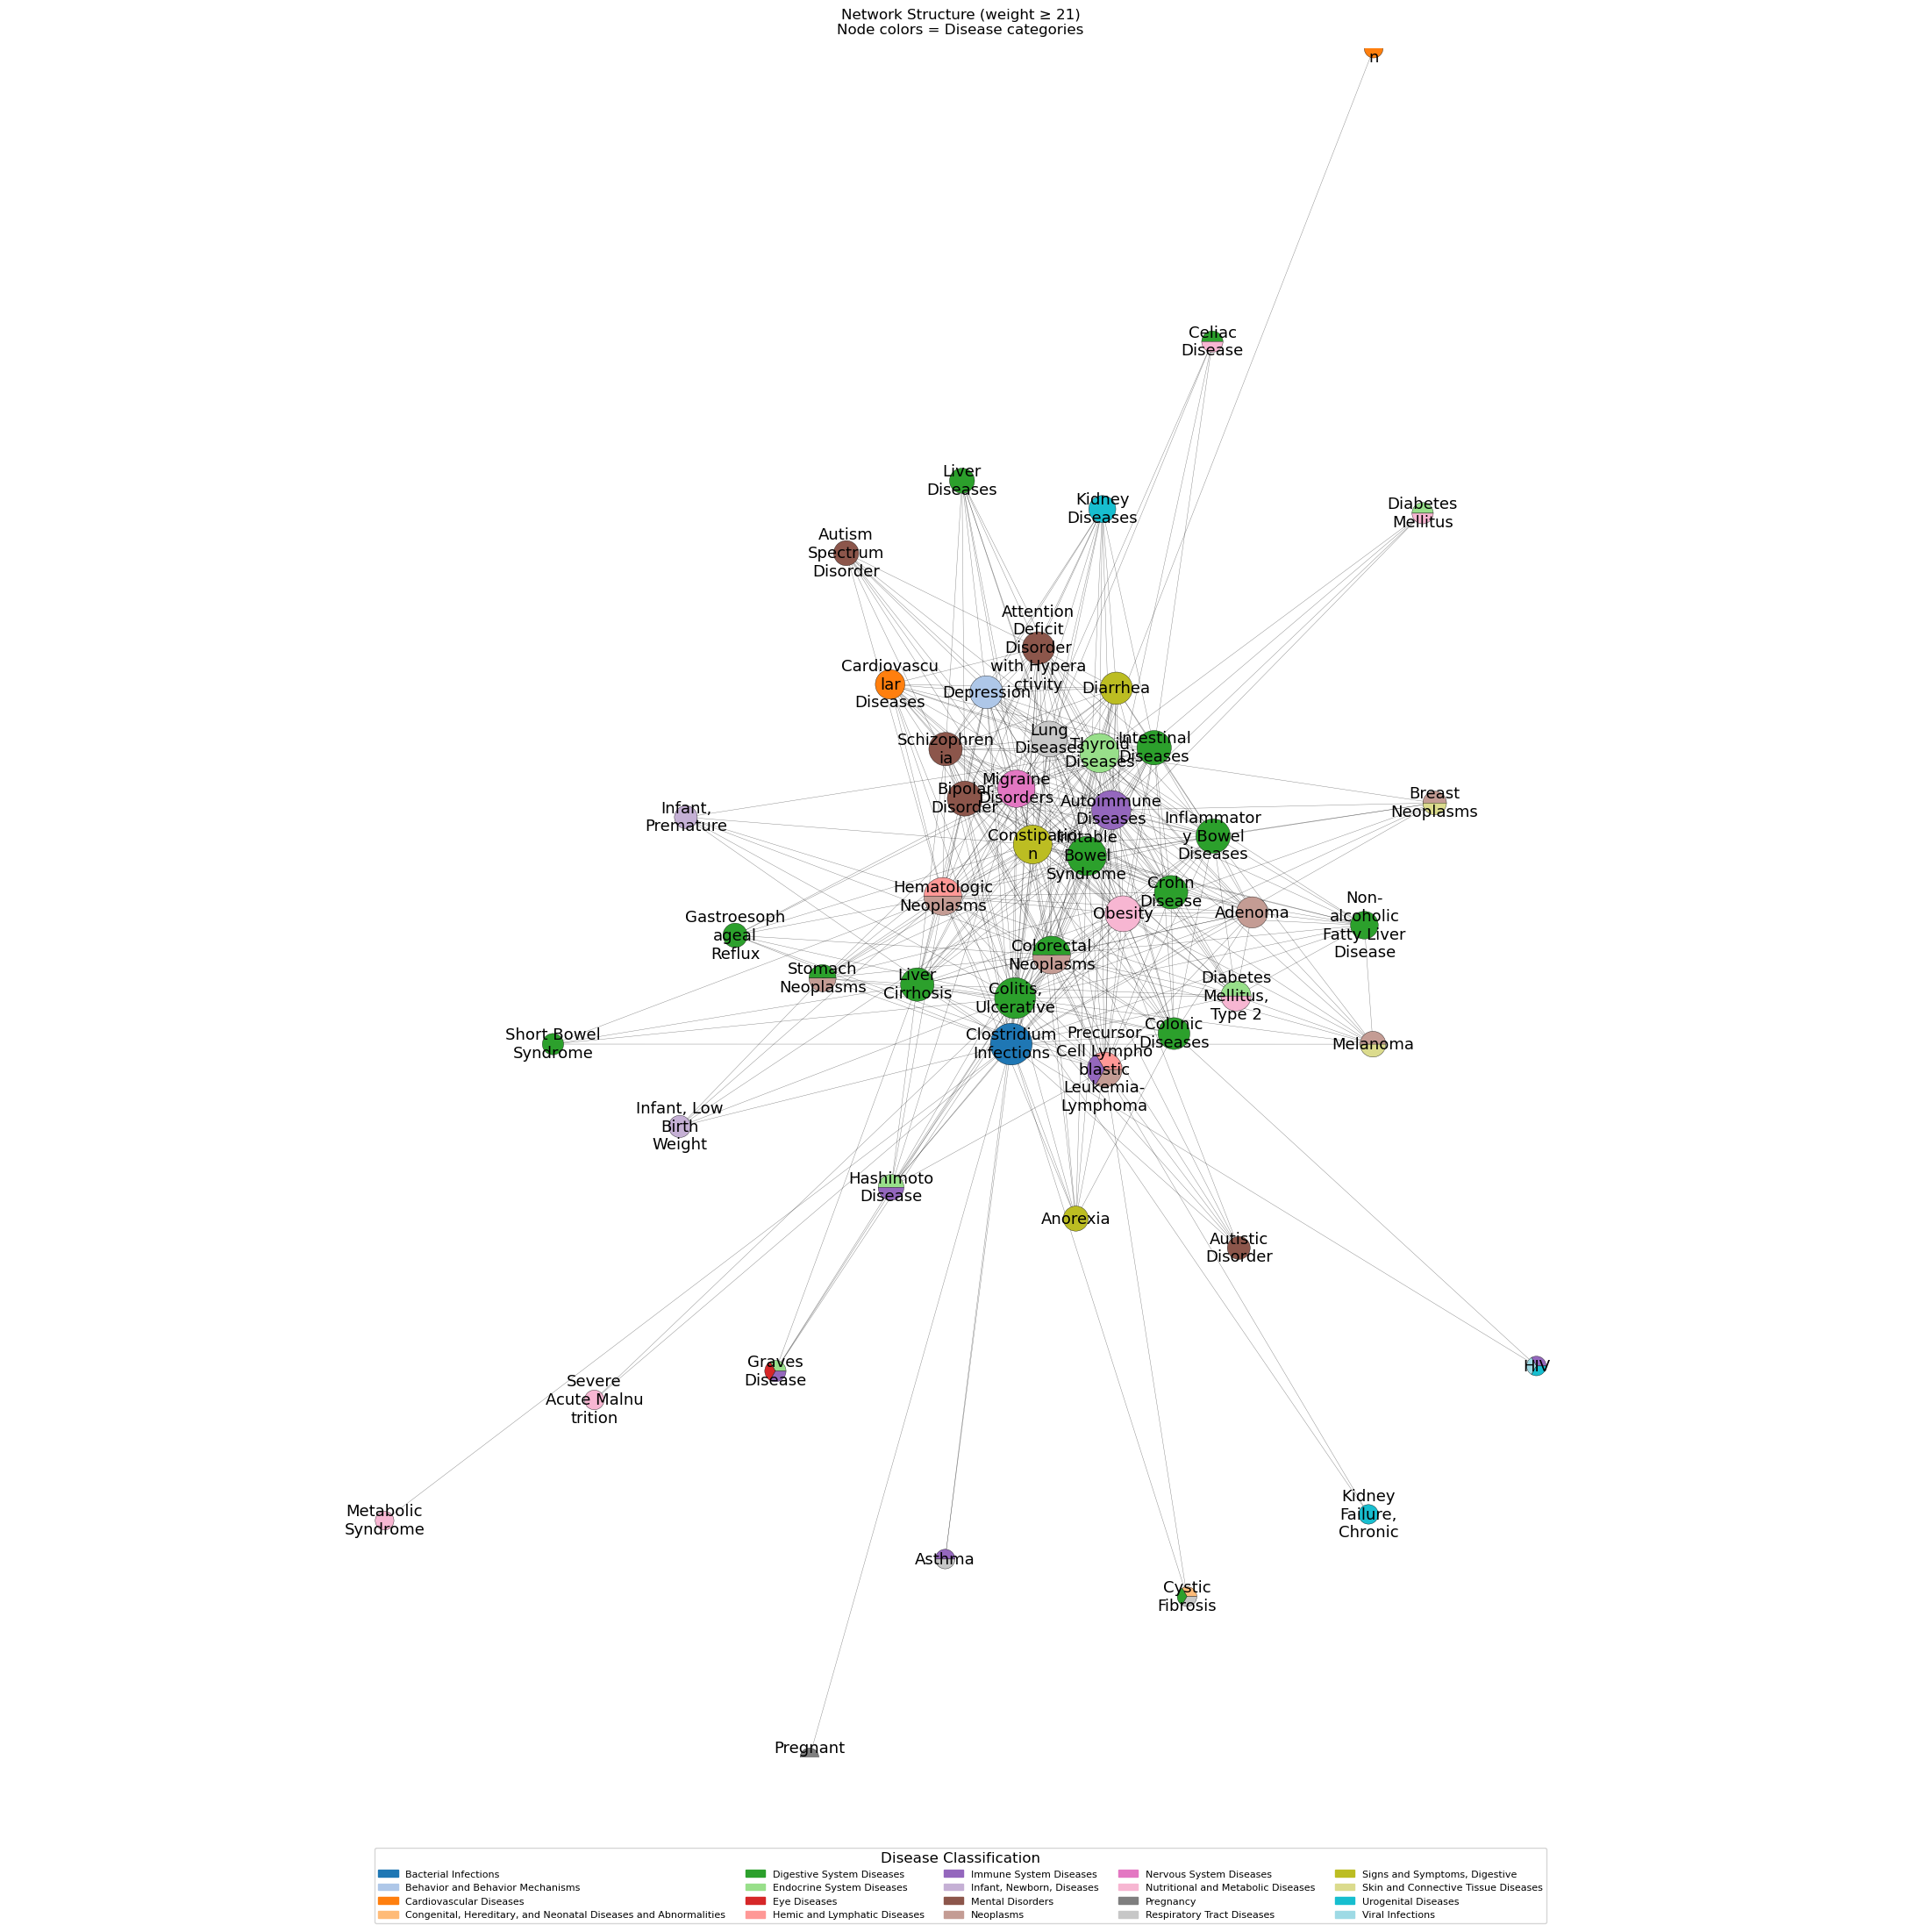

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np

# --- Tunables (spacing without changing layout) ---
scale_factor = 2.0       # >1 spreads nodes apart (no layout recompute)
padding_factor = 0       # extra whitespace around the network

# --- Layout & labels (unchanged physics) ---
pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)  # keep your existing layout
labels = {n: disease_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Inflate positions WITHOUT changing layout parameters ---
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

# --- Node size from degree (AFTER threshold) ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
min_size, max_size = 200, 1000  # points^2
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Normalize categories per node & collect actually used categories ---
node_cats = {}
for n in G_filtered.nodes():
    cats = disease_category_by_id.get(n, [])
    if not isinstance(cats, list) or len(cats) == 0:
        cats = ["(Unclassified)"]
    node_cats[n] = cats
used_categories = sorted({c for cats in node_cats.values() for c in cats})

# --- Color map ONLY for used categories ---
cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Figure & axis ---
fig, ax = plt.subplots(figsize=(22, 22))

# Edges first
nx.draw_networkx_edges(G_filtered, pos, width=0.3, alpha=0.5, ax=ax)

# Set axis limits with EXTRA padding (do NOT tightly fit)
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
span_x = xs.max() - xs.min()
span_y = ys.max() - ys.min()
pad_x = span_x * padding_factor if span_x > 0 else 0.1
pad_y = span_y * padding_factor if span_y > 0 else 0.1
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)

# Keep circles round
ax.set_aspect('equal', adjustable='datalim')

# Helper: convert node size (points^2) -> radius in data units
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)          # points
    r_px = r_pts * (fig.dpi / 72.0)             # pixels
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Draw nodes as pie slices
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.25, zorder=2
        )
        ax.add_patch(wedge)

# Labels on top
import textwrap

# Wrap node labels for the plot
wrap_width = 11  # characters before wrapping
labels_wrapped = {
    n: "\n".join(textwrap.wrap(lbl, wrap_width))
    for n, lbl in labels.items()
}

# Labels on top (wrapped)
nx.draw_networkx_labels(
    G_filtered, pos,
    labels=labels_wrapped,
    font_size=13,
    font_color='black',
    #font_weight='bold',
    #bbox=dict(facecolor='lightgrey', edgecolor='none', alpha=0.2, boxstyle='round,pad=0.2'),
    ax=ax
)


ax.set_title(f"Network Structure (weight ≥ {edge_weight_threshold})\nNode colors = Disease categories", pad =12)
ax.axis('off')

# Legend ONLY for used categories - horizontal at bottom
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(
    handles=legend_handles,
    title="Disease Classification",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),   # move below plot
    fancybox=True,
    shadow=False,
    ncol=min(len(used_categories), 5),  # controls columns in legend row
    fontsize=8,
    title_fontsize=12
)

plt.tight_layout()
plt.show()


In [35]:
import networkx as nx
import pandas as pd
import community as community_louvain  # Louvain community detection

# --- Helper: Get name from disease_dict if available ---
def get_name(node):
    return disease_dict.get(node, str(node))

# --- Centrality Measures ---
metrics = {}

# Degree (raw connections)
metrics['Degree'] = dict(G_filtered.degree())

# Degree Centrality (normalized by max possible degree)
metrics['Degree Centrality'] = nx.degree_centrality(G_filtered)

# Closeness Centrality (inverse of avg shortest path to all others)
metrics['Closeness Centrality'] = nx.closeness_centrality(G_filtered)

# Betweenness Centrality (how often a node is on shortest paths)
metrics['Betweenness Centrality'] = nx.betweenness_centrality(G_filtered)

# Eigenvector Centrality (importance via connected important nodes)
try:
    metrics['Eigenvector Centrality'] = nx.eigenvector_centrality(G_filtered, max_iter=1000)
except nx.NetworkXError:
    metrics['Eigenvector Centrality'] = {}

# PageRank (random walk importance)
metrics['PageRank'] = nx.pagerank(G_filtered)

# Harmonic Centrality (closeness variant that handles disconnected graphs)
metrics['Harmonic Centrality'] = nx.harmonic_centrality(G_filtered)

# --- Convert to DataFrame for easy viewing ---
df_metrics = pd.DataFrame(metrics).rename(index=get_name)

# --- Sort and print top 10 for each metric ---
for metric in metrics.keys():
    print(f"\n=== {metric} ===")
    if metric == "Degree":
        print("What it means: Number of direct connections a node has.")
    elif metric == "Degree Centrality":
        print("What it means: Fraction of all possible nodes a node is connected to.")
    elif metric == "Closeness Centrality":
        print("What it means: How close a node is to all others (higher = shorter distances).")
    elif metric == "Betweenness Centrality":
        print("What it means: How often a node acts as a bridge along the shortest path between two other nodes.")
    elif metric == "Eigenvector Centrality":
        print("What it means: Importance of a node based on being connected to other important nodes.")
    elif metric == "PageRank":
        print("What it means: Probability of landing on a node during a random walk (like Google's ranking).")
    elif metric == "Harmonic Centrality":
        print("What it means: Closeness-like measure that handles disconnected graphs better.")

    top10 = df_metrics[metric].sort_values(ascending=False).head(10)
    for name, value in top10.items():
        print(f"{name:40} {value:.4f}")

# --- Global Network Properties ---
print("\n=== Global Network Properties ===")
print(f"Number of nodes: {G_filtered.number_of_nodes()}")
print(f"Number of edges: {G_filtered.number_of_edges()}")
print(f"Density: {nx.density(G_filtered):.4f} - Fraction of possible edges present.")
print(f"Average clustering coefficient: {nx.average_clustering(G_filtered):.4f} - Tendency to form triangles.")
print(f"Transitivity: {nx.transitivity(G_filtered):.4f} - Ratio of triangles to connected triples.")

# Diameter & avg path length only if graph is connected
if nx.is_connected(G_filtered):
    print(f"Diameter: {nx.diameter(G_filtered)} - Longest shortest path.")
    print(f"Average path length: {nx.average_shortest_path_length(G_filtered):.4f} - Mean distance between nodes.")
else:
    print("Graph is disconnected: Diameter and average path length are undefined.")

# --- Community Detection (Louvain) ---
partition = community_louvain.best_partition(G_filtered)
modularity = community_louvain.modularity(partition, G_filtered)
print(f"Modularity (Louvain): {modularity:.4f} - Strength of community structure (higher = more distinct communities).")

# Print top 5 largest communities
from collections import Counter
community_counts = Counter(partition.values())
print("Top 5 community sizes:", community_counts.most_common(5))



=== Degree ===
What it means: Number of direct connections a node has.
Clostridium Infections                   41.0000
Colitis, Ulcerative                      39.0000
Irritable Bowel Syndrome                 35.0000
Autoimmune Diseases                      35.0000
Thyroid Diseases                         35.0000
Constipation                             34.0000
Hematologic Neoplasms                    32.0000
Colorectal Neoplasms                     32.0000
Migraine Disorders                       31.0000
Obesity                                  28.0000

=== Degree Centrality ===
What it means: Fraction of all possible nodes a node is connected to.
Clostridium Infections                   0.8367
Colitis, Ulcerative                      0.7959
Irritable Bowel Syndrome                 0.7143
Autoimmune Diseases                      0.7143
Thyroid Diseases                         0.7143
Constipation                             0.6939
Hematologic Neoplasms                    0.6531
Color

In [36]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import Counter

# Dummy placeholders for G_filtered and taxon_dict for syntax validation.
# These should be defined in the actual environment where the graph is constructed.
# G_filtered = nx.Graph()  # Replace with your filtered graph
# taxon_dict = {}          # Replace with your actual mapping

# --- Helper: Get name from taxon_dict if available ---
def get_name(node):
    return disease_dict.get(node, str(node))

# --- Centrality Measures ---
metrics = {
    'Degree': dict(G_filtered.degree()),
    'Degree Centrality': nx.degree_centrality(G_filtered),
    'Closeness Centrality': nx.closeness_centrality(G_filtered),
    'Betweenness Centrality': nx.betweenness_centrality(G_filtered),
    'PageRank': nx.pagerank(G_filtered),
    'Harmonic Centrality': nx.harmonic_centrality(G_filtered)
}

# Try Eigenvector Centrality
try:
    metrics['Eigenvector Centrality'] = nx.eigenvector_centrality(G_filtered, max_iter=1000)
except nx.NetworkXError:
    metrics['Eigenvector Centrality'] = {}

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics).rename(index=get_name)

# --- Descriptive Statistics ---
desc_stats = df_metrics.describe(percentiles=[.25, .5, .75, .9, .95, .99]).T
desc_stats['range'] = df_metrics.max() - df_metrics.min()
desc_stats['max_node'] = df_metrics.idxmax()
desc_stats['max_value'] = df_metrics.max()

# Sort by median values
desc_stats_sorted = desc_stats.sort_values(by='50%', ascending=False)

# Also prepare a table of top nodes in descending order for each metric
top_nodes_per_metric = {}
for metric in df_metrics.columns:
    sorted_nodes = df_metrics[metric].sort_values(ascending=False)
    top_nodes_per_metric[metric] = sorted_nodes

# --- Global Network Properties ---
global_props = {
    'Number of nodes': G_filtered.number_of_nodes(),
    'Number of edges': G_filtered.number_of_edges(),
    'Density': nx.density(G_filtered),
    'Average clustering coefficient': nx.average_clustering(G_filtered),
    'Transitivity': nx.transitivity(G_filtered),
    'Is connected': nx.is_connected(G_filtered)
}

if global_props['Is connected']:
    global_props['Diameter'] = nx.diameter(G_filtered)
    global_props['Average path length'] = nx.average_shortest_path_length(G_filtered)

desc_stats_sorted, top_nodes_per_metric, global_props


(                           count      mean       std       min       25%       50%       75%       90%       95%       99%       max     range                max_node  max_value
 Harmonic Centrality    50.000000 32.266667  6.533014 22.666667 26.791667 31.750000 37.375000 41.550000 42.000000 44.510000 45.000000 22.333333  Clostridium Infections  45.000000
 Degree                 50.000000 16.440000 12.083316  1.000000  5.250000 14.500000 25.750000 34.100000 35.000000 40.020000 41.000000 40.000000  Clostridium Infections  41.000000
 Closeness Centrality   50.000000  0.601041  0.112573  0.441441  0.501289  0.587016  0.678225  0.766840  0.777778  0.845370  0.859649  0.418208  Clostridium Infections   0.859649
 Degree Centrality      50.000000  0.335510  0.246598  0.020408  0.107143  0.295918  0.525510  0.695918  0.714286  0.816735  0.836735  0.816327  Clostridium Infections   0.836735
 Eigenvector Centrality 50.000000  0.119267  0.076767  0.009237  0.044085  0.119537  0.189390  0.220209  

In [37]:
import json
import networkx as nx
import pandas as pd

# --- Load dictionaries ---
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_dict.json", "r") as f:
    taxon_dict = json.load(f)

with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_classification.json", "r") as f:
    taxon_category_by_id = json.load(f)

# --- Compute centrality metrics on your species-level graph ---
metrics = {
    "Degree": dict(G_filtered.degree()),
    "Degree Centrality": nx.degree_centrality(G_filtered),
    "Closeness Centrality": nx.closeness_centrality(G_filtered),
    "Betweenness Centrality": nx.betweenness_centrality(G_filtered, normalized=True),
    "Eigenvector Centrality": nx.eigenvector_centrality(G_filtered, max_iter=1000),
    "PageRank": nx.pagerank(G_filtered),
    "Harmonic Centrality": nx.harmonic_centrality(G_filtered)
}

# --- Build DataFrame ---
df = pd.DataFrame(metrics)

# Map species + phylum from dicts
df["species"] = df.index.map(lambda x: taxon_dict.get(str(x), str(x)))
df["Phylum"] = df.index.map(lambda x: taxon_category_by_id.get(str(x), "Unknown"))

# Reorder columns
df = df[["species", "Phylum"] + list(metrics.keys())]

# Add ranks for each metric
for col in metrics.keys():
    df[col + " Rank"] = df[col].rank(method="min", ascending=False)

# Sort by degree for readability (optional, you can skip)
df_sorted = df.sort_values("Degree", ascending=False)

# --- Display the whole DataFrame in notebook ---
pd.set_option("display.max_rows", None)   # show all 106 nodes
pd.set_option("display.max_columns", None)  # show all measures + ranks
pd.set_option("display.width", None)  
pd.set_option("display.max_colwidth", None)

df_sorted


species  \
D003015                             Clostridium Infections   
D003093                                Colitis, Ulcerative   
D043183                           Irritable Bowel Syndrome   
D001327                                Autoimmune Diseases   
D013959                                   Thyroid Diseases   
D003248                                       Constipation   
D019337                              Hematologic Neoplasms   
D015179                               Colorectal Neoplasms   
D008881                                 Migraine Disorders   
D009765                                            Obesity   
D008171                                      Lung Diseases   
D054198     Precursor Cell Lymphoblastic Leukemia-Lymphoma   
D001714                                   Bipolar Disorder   
D007410                                Intestinal Diseases   
D015212                        Inflammatory Bowel Diseases   
D003424                                      Crohn Disease   
D012559                                      Schizophrenia   
D008103                                    Liver Cirrhosis   
D003863                                         Depression   
D003967                                           Diarrhea   
D001289      Attention Deficit Disorder with Hyperactivity   
D003108                                   Colonic Diseases   
D000236                                            Adenoma   
D003924                          Diabetes Mellitus, Type 2   
D002318                            Cardiovascular Diseases   
D065626                  Non-alcoholic Fatty Liver Disease   
D013274                                  Stomach Neoplasms   
D007674                                    Kidney Diseases   
D050031                                  Hashimoto Disease   
D008545                                           Melanoma   
D000855                                           Anorexia   
D000067877                        Autism Spectrum Disorder   
D008107                                     Liver Diseases   
D005764                            Gastroesophageal Reflux   
D001943                                   Breast Neoplasms   
D007234                                  Infant, Premature   
D001321                                  Autistic Disorder   
D007230                           Infant, Low Birth Weight   
D012778                               Short Bowel Syndrome   
D002446                                     Celiac Disease   
D006111                                     Graves Disease   
D003920                                  Diabetes Mellitus   
D003550                                    Cystic Fibrosis   
D007676                            Kidney Failure, Chronic   
D001249                                             Asthma   
D000067011                       Severe Acute Malnutrition   
D006678                                                HIV   
D006973                                       Hypertension   
D024821                                 Metabolic Syndrome   
D037841                                    Pregnant People   

                                                                                                                              Phylum  \
D003015                                                                                                       [Bacterial Infections]   
D003093                                                                                                  [Digestive System Diseases]   
D043183                                                                                                  [Digestive System Diseases]   
D001327                                                                                                     [Immune System Diseases]   
D013959                                                                                                  [Endocrine System Diseases]   
D003248                                                                 

In [38]:
# --- Summary statistics for all centrality measures ---
summary = df.drop(columns=["Genus", "Phylum"]).describe(
    percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
).T

# Add range and median explicitly
summary["range"] = summary["max"] - summary["min"]
summary["median"] = df.drop(columns=["Genus", "Phylum"]).median()

# --- Display results ---
print("\n===== Node-level metrics (all genera) =====\n")
display(df_sorted)  # full DataFrame with genus + phylum + all centralities + ranks

print("\n===== Summary statistics for each metric =====\n")
display(summary)


KeyError: "['Genus'] not found in axis"

/tmp/slurm.4730828/ipykernel_3960228/3630715960.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


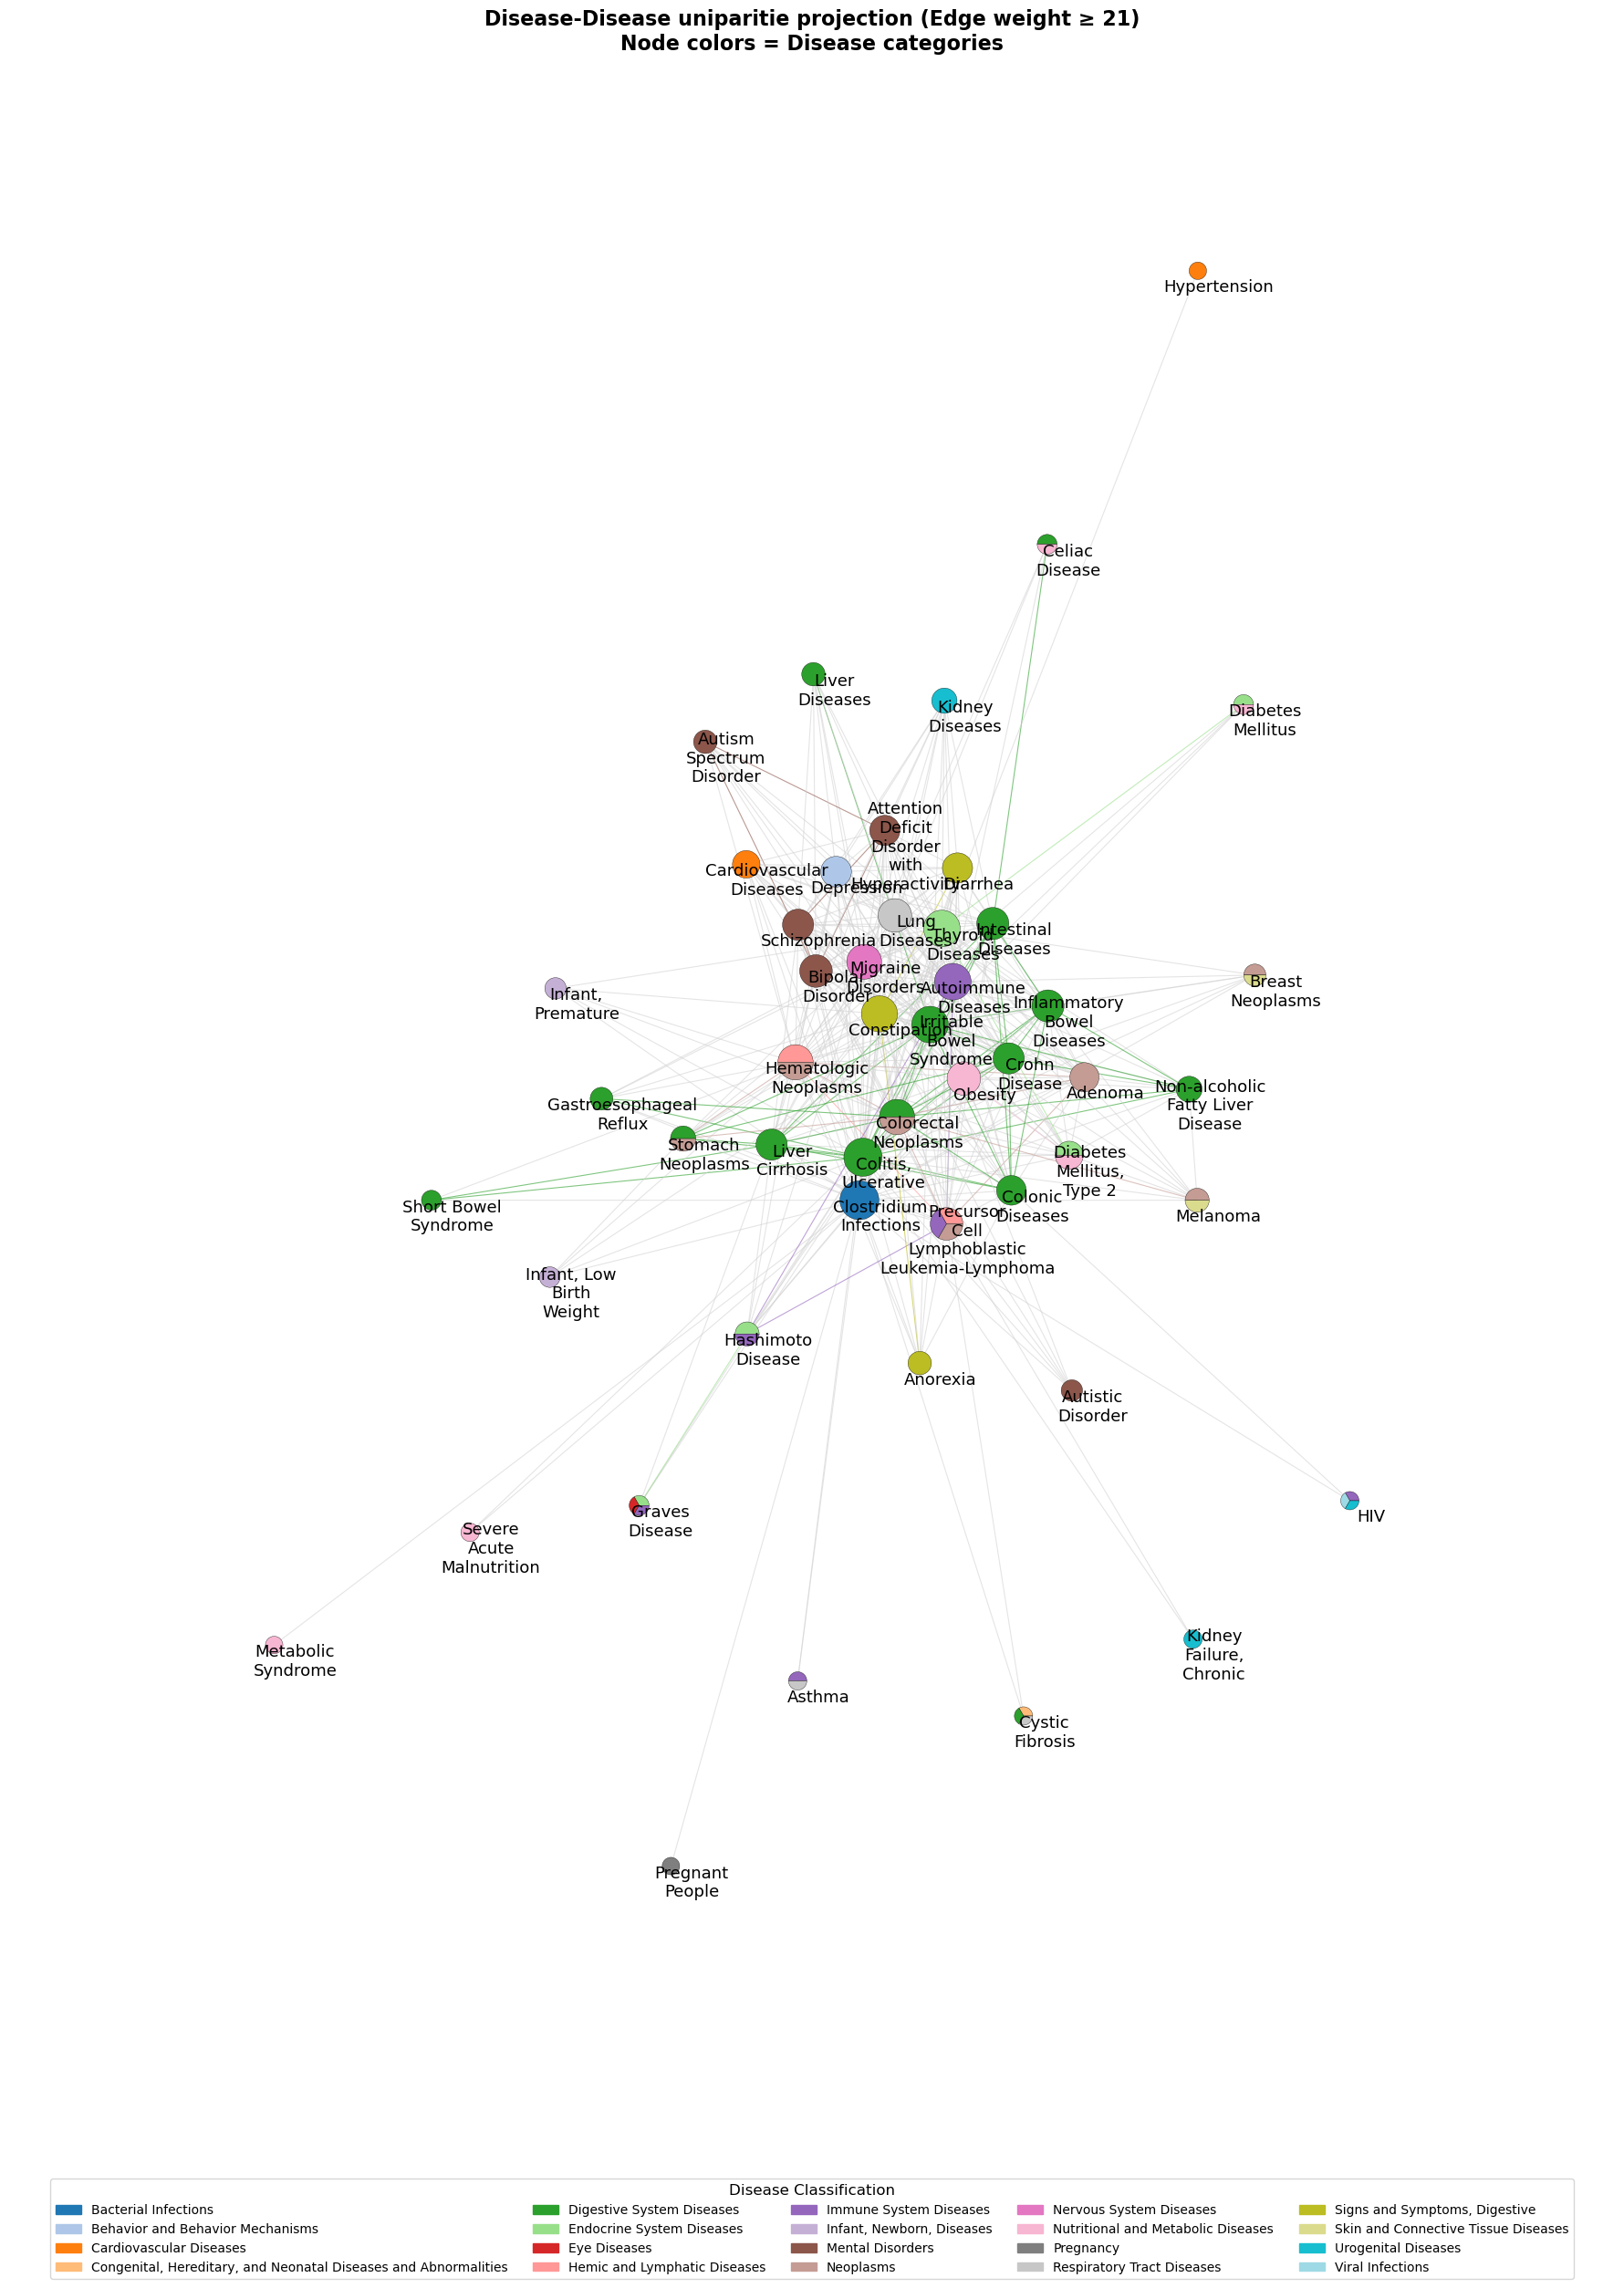

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import textwrap

# --- Tunables ---
scale_factor = 2.0
padding_factor = 0
wrap_width = 11
font_size = 13

min_size, max_size = 200, 1000
edge_width = 0.8
edge_alpha = 0.6

# --- Layout ---
pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)
labels = {n: disease_dict.get(n, str(n)) for n in G_filtered.nodes()}
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

# --- Node size ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Categories ---
node_cats = {}
for n in G_filtered.nodes():
    cats = disease_category_by_id.get(n, [])
    if not isinstance(cats, list) or len(cats) == 0:
        cats = ["(Unclassified)"]
    node_cats[n] = cats

used_categories = sorted({c for cats in node_cats.values() for c in cats})
cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Edge colors based on category ---
edge_colors = []
for u, v in G_filtered.edges():
    cats_u = node_cats.get(u, [])
    cats_v = node_cats.get(v, [])
    # if they share a category, use that category's color
    shared = set(cats_u) & set(cats_v)
    if shared:
        cat = list(shared)[0]  # take first shared category
        edge_colors.append(category_colors.get(cat, "grey"))
    else:
        edge_colors.append("lightgrey")

# --- Plot ---
fig, ax = plt.subplots(figsize=(22, 22))

# Draw edges with custom colors
nx.draw_networkx_edges(
    G_filtered,
    pos,
    width=edge_width,
    alpha=edge_alpha,
    edge_color=edge_colors,
    ax=ax
)

# Helper: points² → radius in data units
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)
    r_px = r_pts * (fig.dpi / 72.0)
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Axis limits
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
span_x = xs.max() - xs.min()
span_y = ys.max() - ys.min()
pad_x = span_x * padding_factor if span_x > 0 else 0.1
pad_y = span_y * padding_factor if span_y > 0 else 0.1
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)
ax.set_aspect('equal', adjustable='datalim')

# Nodes as pies
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.25, zorder=2
        )
        ax.add_patch(wedge)

# Labels - wrap without breaking words, then offset down and right
labels_wrapped = {
    n: "\n".join(
        textwrap.wrap(
            lbl,
            wrap_width,
            break_long_words=False,
            break_on_hyphens=False
        )
    )
    for n, lbl in labels.items()
}

# Offset positions for labels (down and right)
label_pos = {n: (x + 0.05, y - 0.04) for n, (x, y) in pos.items()}

nx.draw_networkx_labels(
    G_filtered, label_pos,
    labels=labels_wrapped,
    font_size=font_size,
    font_color='black',
    ax=ax
)

# Legend
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(
    handles=legend_handles,
    title="Disease Classification",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(len(used_categories), 5),
    fontsize=10,
    title_fontsize=12
)

ax.set_title(f"Disease-Disease uniparitie projection (Edge weight ≥ {edge_weight_threshold})\nNode colors = Disease categories", fontweight='bold', fontsize=16, pad=12)
ax.axis('off')
plt.tight_layout()
# Place this just before plt.show()
pos_bounds = [0.1, 0.5, 0.8, 1]  # [left, bottom, width, height] in figure coords
ax.set_position(pos_bounds)
plt.show()


/tmp/slurm.4730828/ipykernel_3960228/2874454031.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


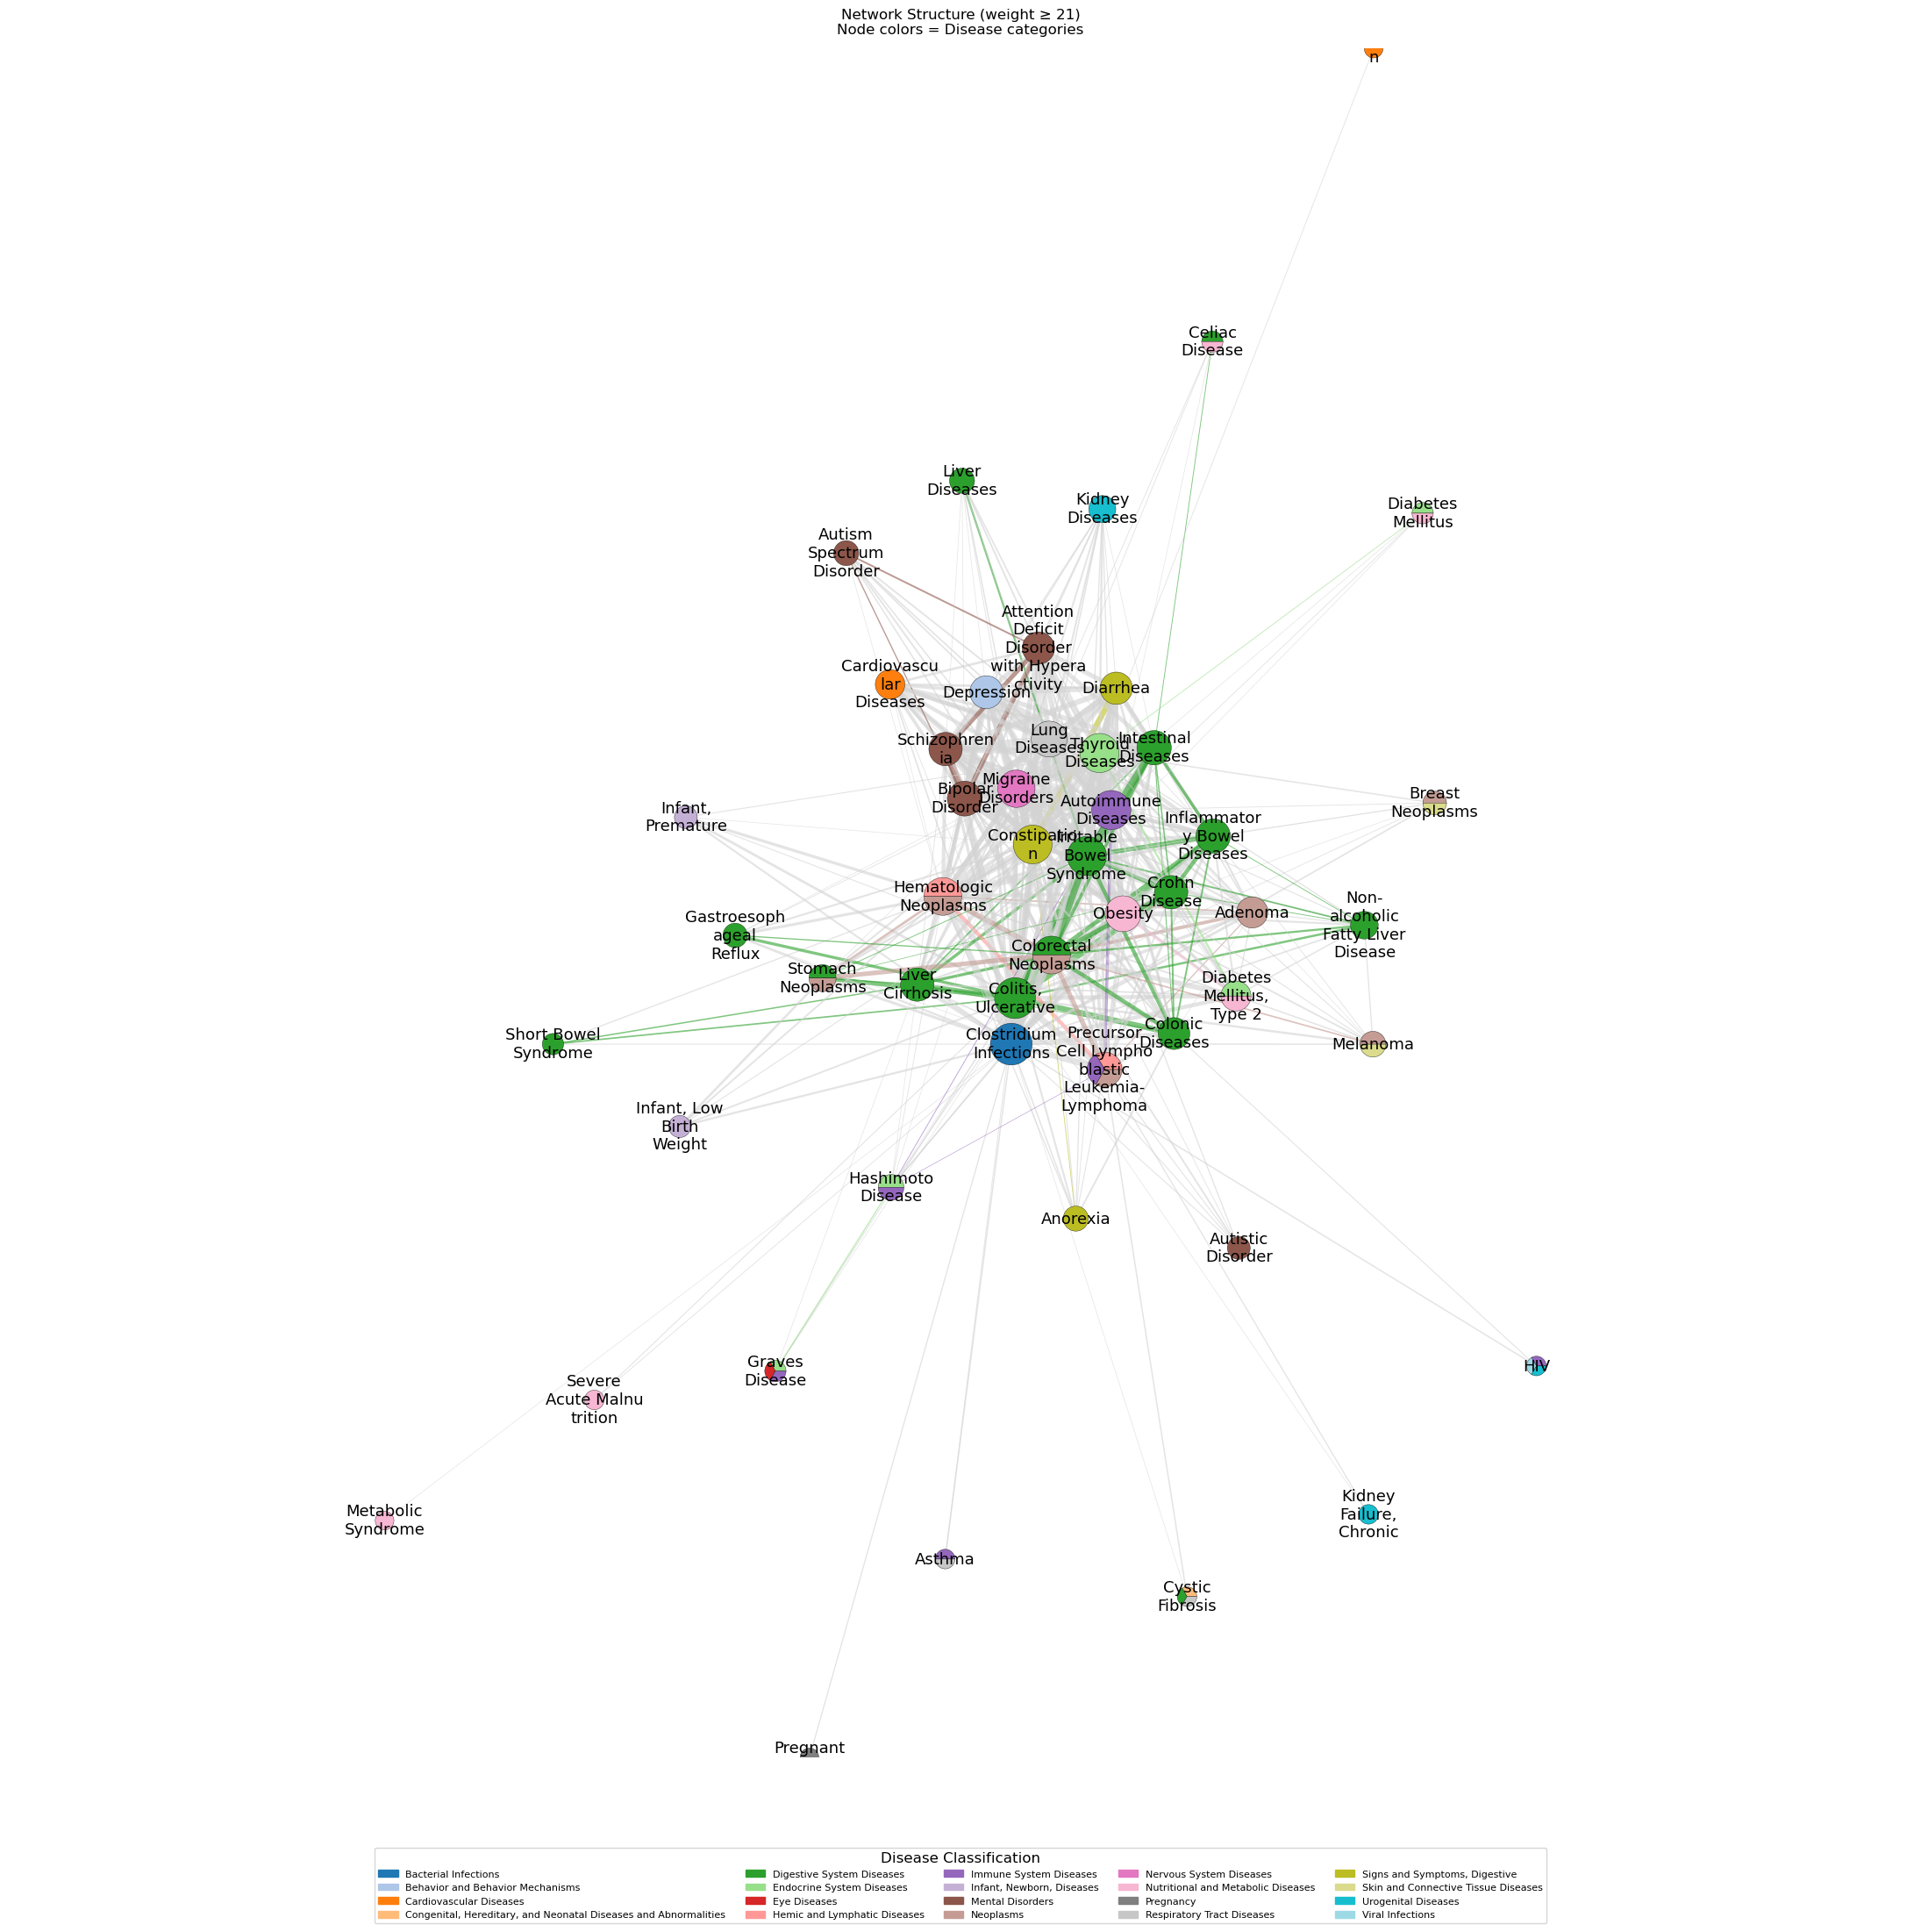

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import textwrap
import math

# --- Tunables ---
scale_factor = 2.0
padding_factor = 0
wrap_width = 11
font_size = 13

min_size, max_size = 200, 1000
edge_alpha = 0.6
min_w, max_w = 0.5, 8.0  # exaggerated range for edge thickness

# --- Layout ---
pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)
labels = {n: disease_dict.get(n, str(n)) for n in G_filtered.nodes()}
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

# --- Node size ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Categories ---
node_cats = {}
for n in G_filtered.nodes():
    cats = disease_category_by_id.get(n, [])
    if not isinstance(cats, list) or len(cats) == 0:
        cats = ["(Unclassified)"]
    node_cats[n] = cats

used_categories = sorted({c for cats in node_cats.values() for c in cats})
cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Edge colors & widths (log²-scaled, exaggerated range) ---
weights = [G_filtered[u][v].get("weight", 1.0) for u, v in G_filtered.edges()]
if weights:
    w_min, w_max = min(weights), max(weights)
    log_min = math.log(w_min + 1)
    log_max = math.log(w_max + 1)
    edge_widths = [
        min_w + ((math.log(w + 1)**2 - log_min**2) / (log_max**2 - log_min**2) if log_max > log_min else 0) * (max_w - min_w)
        for w in weights
    ]
else:
    edge_widths = [min_w] * len(G_filtered.edges())

edge_colors = []
for (u, v), w in zip(G_filtered.edges(), edge_widths):
    cats_u = node_cats.get(u, [])
    cats_v = node_cats.get(v, [])
    shared = set(cats_u) & set(cats_v)
    if shared:
        cat = list(shared)[0]
        edge_colors.append(category_colors.get(cat, "grey"))
    else:
        edge_colors.append("lightgrey")

# --- Plot ---
fig, ax = plt.subplots(figsize=(22, 22))

nx.draw_networkx_edges(
    G_filtered,
    pos,
    width=edge_widths,
    alpha=edge_alpha,
    edge_color=edge_colors,
    ax=ax
)

# Helper: points² → radius in data units
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)
    r_px = r_pts * (fig.dpi / 72.0)
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Axis limits
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
span_x = xs.max() - xs.min()
span_y = ys.max() - ys.min()
pad_x = span_x * padding_factor if span_x > 0 else 0.1
pad_y = span_y * padding_factor if span_y > 0 else 0.1
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)
ax.set_aspect('equal', adjustable='datalim')

# Nodes as pies
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.25, zorder=2
        )
        ax.add_patch(wedge)

# Labels
labels_wrapped = {n: "\n".join(textwrap.wrap(lbl, wrap_width)) for n, lbl in labels.items()}
nx.draw_networkx_labels(
    G_filtered, pos,
    labels=labels_wrapped,
    font_size=font_size,
    font_color='black',
    ax=ax
)

# Legend
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(
    handles=legend_handles,
    title="Disease Classification",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(len(used_categories), 5),
    fontsize=8,
    title_fontsize=12
)

ax.set_title(f"Network Structure (weight ≥ {edge_weight_threshold})\nNode colors = Disease categories", pad=12)
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# --- One-time installs (run in a separate cell if needed) ---
# !pip install ipycytoscape ipywidgets

import io, base64
import ipycytoscape
import matplotlib.pyplot as plt
import textwrap
from IPython.display import HTML, display

# ========= Helpers =========

def rgba_to_hex(rgba):
    """Matplotlib RGBA (0..1) -> '#rrggbb' hex (alpha ignored)."""
    r, g, b = [int(255 * x) for x in rgba[:3]]
    return f"#{r:02x}{g:02x}{b:02x}"

def pie_png_b64(colors_hex, size_px=96):
    """
    Make a small transparent PNG pie and return as data URL (base64).
    No borders (no grey outline), seamless slices.
    """
    fig = plt.figure(figsize=(size_px/96, size_px/96), dpi=96)
    fig.patch.set_alpha(0)            # transparent fig
    ax = plt.axes([0, 0, 1, 1])
    ax.set_axis_off()
    ax.patch.set_alpha(0)             # transparent axes

    if not colors_hex:
        colors_hex = ["#cccccc"]

    sizes = [1] * len(colors_hex)
    ax.pie(
        sizes,
        colors=colors_hex,
        startangle=90,
        wedgeprops=dict(edgecolor='none', linewidth=0),  # no slice borders
    )

    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=96, transparent=True)  # keep alpha
    plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

# ========= Map node sizes to pixel size =========
ns_min, ns_max = float(min(node_sizes)), float(max(node_sizes))
def size_pts2_to_px(s, px_min=36, px_max=140):
    if ns_max > ns_min:
        t = (float(s) - ns_min) / (ns_max - ns_min)
    else:
        t = 1.0
    return int(px_min + t * (px_max - px_min))

# To handle ipycytoscape stringifying node IDs internally
key_by_str = {str(k): k for k in G_filtered.nodes()}

# ========= Per-node images & data =========
node_img_data = {}
node_px_size  = {}

for n in G_filtered.nodes():
    cats = node_cats[n]
    slice_cols = [rgba_to_hex(category_colors.get(c, (0.8, 0.8, 0.8, 1.0))) for c in cats]
    px = size_pts2_to_px(node_sizes[list(G_filtered.nodes()).index(n)])
    node_px_size[n]  = px
    node_img_data[n] = pie_png_b64(slice_cols, size_px=px)

# ========= Edge colour/width maps =========
edge_color_map = {}
edge_width_map = {}
edges_list = list(G_filtered.edges())

for ((u, v), w, c) in zip(edges_list, edge_widths, edge_colors):
    c_hex = rgba_to_hex(c) if isinstance(c, tuple) else c
    edge_color_map[(str(u), str(v))] = c_hex
    edge_color_map[(str(v), str(u))] = c_hex
    edge_width_map[(str(u), str(v))] = float(w)
    edge_width_map[(str(v), str(u))] = float(w)

# ========= Build Cytoscape widget =========
cyto = ipycytoscape.CytoscapeWidget()
cyto.layout.width = '1200px'
cyto.layout.height = '900px'

# Add graph
cyto.graph.add_graph_from_networkx(G_filtered)

# ========= Center-expansion spacing logic =========
xs = [p[0] for p in pos.values()]
ys = [p[1] for p in pos.values()]
center_x = (max(xs) + min(xs)) / 2
center_y = (max(ys) + min(ys)) / 2

# Parameters controlling the effect
max_extra_scale = 2.0     # how much more to scale the closest-to-center nodes
influence_radius = 0.5    # fraction of max radius where scaling fades to 1.0
base_spacing = 2000.0     # baseline spacing multiplier for all nodes

# Max distance from center
max_dist = max(((p[0] - center_x)**2 + (p[1] - center_y)**2)**0.5 for p in pos.values())

# Adjusted positions
pos_adjusted = {}
for n, (x, y) in pos.items():
    dx = x - center_x
    dy = y - center_y
    dist = (dx**2 + dy**2)**0.5
    norm_dist = dist / max_dist if max_dist else 0

    if norm_dist < influence_radius:
        # Push central nodes outward more
        scale_factor = max_extra_scale - (max_extra_scale - 1.0) * (norm_dist / influence_radius)
    else:
        scale_factor = 1.0  # leave peripheral nodes mostly unchanged

    pos_adjusted[n] = (center_x + dx * scale_factor * base_spacing,
                       center_y + dy * scale_factor * base_spacing)

# ========= Wrapped labels =========
labels_wrapped = {
    n: "\n".join(textwrap.wrap(labels.get(n, str(n)), width=wrap_width, break_long_words=False, break_on_hyphens=False))
    for n in G_filtered.nodes()
}

# ========= Apply node attributes =========
for node in cyto.graph.nodes:
    node_id_raw = node.data['id']
    node_id_str = str(node_id_raw)
    node_key    = key_by_str.get(node_id_str, node_id_raw)

    node.data['label'] = labels_wrapped.get(node_key, str(node_key))
    node.data['img']   = node_img_data[node_key]
    node.data['w']     = node_px_size[node_key]
    node.data['h']     = node_px_size[node_key]

    x, y = pos_adjusted[node_key]
    node.position = {'x': float(x), 'y': float(y)}

# ========= Apply edge attributes =========
for edge in cyto.graph.edges:
    u_str = str(edge.data['source'])
    v_str = str(edge.data['target'])
    edge.data['color'] = edge_color_map.get((u_str, v_str), "#cccccc")
    edge.data['w']     = edge_width_map.get((u_str, v_str), 1.0)

# ========= Style =========
cyto.set_style([
    {
        'selector': 'node',
        'style': {
            'background-image': 'data(img)',
            'background-fit': 'cover',
            'background-image-opacity': 1,
            'background-color': '#000000',
            'background-opacity': 0,
            'shape': 'ellipse',
            'width': 'data(w)',
            'height': 'data(h)',
            'label': 'data(label)',
            'font-size': f'{font_size}px',
            'color': 'black',
            'text-valign': 'center',
            'text-halign': 'center',
            'text-wrap': 'wrap',
            'text-max-width': '140px',
            'border-width': 0,
            'border-opacity': 0,
            'overlay-opacity': 0
        }
    },
    {
        'selector': 'edge',
        'style': {
            'line-color': 'data(color)',
            'width': 'data(w)',
            'opacity': 0.7,
            'curve-style': 'bezier'
        }
    }
])

# ========= Use preset layout =========
cyto.set_layout(name='preset')
display(cyto)

# ========= Legend =========
legend_bits = []
for cat in used_categories:
    hexcol = rgba_to_hex(category_colors[cat])
    legend_bits.append(
        f'<span style="display:inline-block;width:12px;height:12px;background:{hexcol};'
        f'border:1px solid #000;margin-right:6px;"></span>'
        f'<span style="margin-right:16px;font-size:12px;">{cat}</span>'
    )
legend_html = "<div style='margin-top:8px;'>" + "".join(legend_bits) + "</div>"
display(HTML(f"<b>Disease Classification</b>{legend_html}"))


CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'style': {'backgrou…

In [ ]:
# --- One-time installs (run in a separate cell if needed) ---
# !pip install ipycytoscape ipywidgets

import io, base64
import ipycytoscape
import matplotlib.pyplot as plt
import textwrap
from IPython.display import HTML, display

# ========= Helpers =========

def rgba_to_hex(rgba):
    """Matplotlib RGBA (0..1) -> '#rrggbb' hex (alpha ignored)."""
    r, g, b = [int(255 * x) for x in rgba[:3]]
    return f"#{r:02x}{g:02x}{b:02x}"

def pie_png_b64(colors_hex, size_px=96):
    """
    Make a small transparent PNG pie and return as data URL (base64).
    No borders (no grey outline), seamless slices.
    """
    fig = plt.figure(figsize=(size_px/96, size_px/96), dpi=96)
    fig.patch.set_alpha(0)            # transparent fig
    ax = plt.axes([0, 0, 1, 1])
    ax.set_axis_off()
    ax.patch.set_alpha(0)             # transparent axes

    if not colors_hex:
        colors_hex = ["#cccccc"]

    sizes = [1] * len(colors_hex)
    ax.pie(
        sizes,
        colors=colors_hex,
        startangle=90,
        wedgeprops=dict(edgecolor='none', linewidth=0),  # no slice borders
    )

    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=96, transparent=True)  # keep alpha
    plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

# ========= Map node sizes to pixel size (larger max) =========
ns_min, ns_max = float(min(node_sizes)), float(max(node_sizes))
def size_pts2_to_px(s, px_min=36, px_max=180):  # was 140, now 180
    if ns_max > ns_min:
        t = (float(s) - ns_min) / (ns_max - ns_min)
    else:
        t = 1.0
    return int(px_min + t * (px_max - px_min))

# To handle ipycytoscape stringifying node IDs internally
key_by_str = {str(k): k for k in G_filtered.nodes()}

# ========= Per-node images & data =========
node_img_data = {}
node_px_size  = {}

for n in G_filtered.nodes():
    cats = node_cats[n]
    slice_cols = [rgba_to_hex(category_colors.get(c, (0.8, 0.8, 0.8, 1.0))) for c in cats]
    px = size_pts2_to_px(node_sizes[list(G_filtered.nodes()).index(n)])
    node_px_size[n]  = px
    node_img_data[n] = pie_png_b64(slice_cols, size_px=px)

# ========= Edge colour/width maps =========
edge_color_map = {}
edge_width_map = {}
edges_list = list(G_filtered.edges())

for ((u, v), w, c) in zip(edges_list, edge_widths, edge_colors):
    c_hex = rgba_to_hex(c) if isinstance(c, tuple) else c
    edge_color_map[(str(u), str(v))] = c_hex
    edge_color_map[(str(v), str(u))] = c_hex
    edge_width_map[(str(u), str(v))] = float(w)
    edge_width_map[(str(v), str(u))] = float(w)

# ========= Build Cytoscape widget =========
cyto = ipycytoscape.CytoscapeWidget()
cyto.layout.width = '1200px'
cyto.layout.height = '900px'

# Add graph
cyto.graph.add_graph_from_networkx(G_filtered)

# ========= Center-expansion spacing logic (more spread) =========
xs = [p[0] for p in pos.values()]
ys = [p[1] for p in pos.values()]
center_x = (max(xs) + min(xs)) / 2
center_y = (max(ys) + min(ys)) / 2

# Parameters controlling the effect
max_extra_scale = 2.0      # extra push for central nodes
influence_radius = 0.5     # fraction of radius where push applies
base_spacing = 3000.0      # was 2000, now 3000 for more spread

# Max distance from center
max_dist = max(((p[0] - center_x)**2 + (p[1] - center_y)**2)**0.5 for p in pos.values())

# Adjusted positions
pos_adjusted = {}
for n, (x, y) in pos.items():
    dx = x - center_x
    dy = y - center_y
    dist = (dx**2 + dy**2)**0.5
    norm_dist = dist / max_dist if max_dist else 0

    if norm_dist < influence_radius:
        scale_factor = max_extra_scale - (max_extra_scale - 1.0) * (norm_dist / influence_radius)
    else:
        scale_factor = 1.0

    pos_adjusted[n] = (center_x + dx * scale_factor * base_spacing,
                       center_y + dy * scale_factor * base_spacing)

# ========= Wrapped labels =========
labels_wrapped = {
    n: "\n".join(textwrap.wrap(labels.get(n, str(n)), width=wrap_width, break_long_words=False, break_on_hyphens=False))
    for n in G_filtered.nodes()
}

# ========= Apply node attributes =========
for node in cyto.graph.nodes:
    node_id_raw = node.data['id']
    node_id_str = str(node_id_raw)
    node_key    = key_by_str.get(node_id_str, node_id_raw)

    node.data['label'] = labels_wrapped.get(node_key, str(node_key))
    node.data['img']   = node_img_data[node_key]
    node.data['w']     = node_px_size[node_key]
    node.data['h']     = node_px_size[node_key]

    x, y = pos_adjusted[node_key]
    node.position = {'x': float(x), 'y': float(y)}

# ========= Apply edge attributes =========
for edge in cyto.graph.edges:
    u_str = str(edge.data['source'])
    v_str = str(edge.data['target'])
    edge.data['color'] = edge_color_map.get((u_str, v_str), "#cccccc"),
    edge.data['w']     = edge_width_map.get((u_str, v_str), 1.0)
    
# ========= Style (bigger font size) =========
cyto.set_style([
    {
        'selector': 'node',
        'style': {
            'background-image': 'data(img)',
            'background-fit': 'cover',
            'background-image-opacity': 1,
            'background-color': '#000000',
            'background-opacity': 0,
            'shape': 'ellipse',
            'width': 'data(w)',
            'height': 'data(h)',
            'label': 'data(label)',
            'font-size': f'{font_size + 44}px',  # bigger labels
            'color': 'black',
            'text-valign': 'bottom',      # vertical position (top, center, bottom)
            'text-halign': 'right',        # horizontal position (left, center, right)
            'text-margin-x': -10,         # move label left (negative = left)
            'text-margin-y': 8,           # move label down (positive = down if valign=bottom)
            'text-wrap': 'wrap',
            'text-max-width': '160px',  # slightly wider
            'border-width': 0,
            'border-opacity': 0,
            'overlay-opacity': 0
        }
    },
    {
        'selector': 'edge',
        'style': {
            'line-color': 'data(color)',
            'width': 'data(w)',
            'opacity': 0.2,
            'curve-style': 'bezier'
        }
    }
])

# ========= Use preset layout =========
cyto.set_layout(name='preset')
display(cyto)

# ========= Legend =========
legend_bits = []
for cat in used_categories:
    hexcol = rgba_to_hex(category_colors[cat])
    legend_bits.append(
        f'<span style="display:inline-block;width:12px;height:12px;background:{hexcol};'
        f'border:1px solid #000;margin-right:6px;"></span>'
        f'<span style="margin-right:16px;font-size:16px;">{cat}</span>'
    )
legend_html = "<div style='margin-top:8px;'>" + "".join(legend_bits) + "</div>"
display(HTML(f"<b>Disease Classification</b>{legend_html}"))


CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'style': {'backgrou…

In [ ]:
# --- One-time installs (run in a separate cell if needed) ---
# !pip install ipycytoscape ipywidgets

import io, base64
import ipycytoscape
import matplotlib.pyplot as plt
import textwrap
from IPython.display import HTML, display

# ========= Helpers =========

def rgba_to_hex(rgba):
    """Matplotlib RGBA (0..1) -> '#rrggbb' hex (alpha ignored)."""
    r, g, b = [int(255 * x) for x in rgba[:3]]
    return f"#{r:02x}{g:02x}{b:02x}"

def pie_png_b64(colors_hex, size_px=96):
    """Make a small transparent PNG pie and return as data URL (base64)."""
    fig = plt.figure(figsize=(size_px/96, size_px/96), dpi=96)
    fig.patch.set_alpha(0)
    ax = plt.axes([0, 0, 1, 1])
    ax.set_axis_off()
    ax.patch.set_alpha(0)

    if not colors_hex:
        colors_hex = ["#cccccc"]

    sizes = [1] * len(colors_hex)
    ax.pie(
        sizes,
        colors=colors_hex,
        startangle=90,
        wedgeprops=dict(edgecolor='none', linewidth=0),
    )

    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=96, transparent=True)
    plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

# ========= Map node sizes to pixel size =========
ns_min, ns_max = float(min(node_sizes)), float(max(node_sizes))
def size_pts2_to_px(s, px_min=36, px_max=180):
    if ns_max > ns_min:
        t = (float(s) - ns_min) / (ns_max - ns_min)
    else:
        t = 1.0
    return int(px_min + t * (px_max - px_min))

key_by_str = {str(k): k for k in G_filtered.nodes()}

# ========= Per-node images & data =========
node_img_data = {}
node_px_size  = {}
for n in G_filtered.nodes():
    cats = node_cats[n]
    slice_cols = [rgba_to_hex(category_colors.get(c, (0.8, 0.8, 0.8, 1.0))) for c in cats]
    px = size_pts2_to_px(node_sizes[list(G_filtered.nodes()).index(n)])
    node_px_size[n]  = px
    node_img_data[n] = pie_png_b64(slice_cols, size_px=px)

# ========= Edge colour/width maps =========
edge_color_map = {}
edge_width_map = {}
edges_list = list(G_filtered.edges())

for ((u, v), w, c) in zip(edges_list, edge_widths, edge_colors):
    c_hex = rgba_to_hex(c) if isinstance(c, tuple) else c
    edge_color_map[(str(u), str(v))] = c_hex
    edge_color_map[(str(v), str(u))] = c_hex
    edge_width_map[(str(u), str(v))] = float(w)
    edge_width_map[(str(v), str(u))] = float(w)

# ========= Build Cytoscape widget =========
cyto = ipycytoscape.CytoscapeWidget()
cyto.layout.width = '1200px'
cyto.layout.height = '900px'

# Add graph
cyto.graph.add_graph_from_networkx(G_filtered)

# ========= Center-expansion spacing logic =========
xs = [p[0] for p in pos.values()]
ys = [p[1] for p in pos.values()]
center_x = (max(xs) + min(xs)) / 2
center_y = (max(ys) + min(ys)) / 2

max_extra_scale = 2.0
influence_radius = 0.5
base_spacing = 3000.0
max_dist = max(((p[0] - center_x)**2 + (p[1] - center_y)**2)**0.5 for p in pos.values())

pos_adjusted = {}
for n, (x, y) in pos.items():
    dx = x - center_x
    dy = y - center_y
    dist = (dx**2 + dy**2)**0.5
    norm_dist = dist / max_dist if max_dist else 0
    if norm_dist < influence_radius:
        scale_factor = max_extra_scale - (max_extra_scale - 1.0) * (norm_dist / influence_radius)
    else:
        scale_factor = 1.0
    pos_adjusted[n] = (center_x + dx * scale_factor * base_spacing,
                       center_y + dy * scale_factor * base_spacing)

# ========= Wrapped labels =========
labels_wrapped = {
    n: "\n".join(textwrap.wrap(labels.get(n, str(n)), width=wrap_width,
                               break_long_words=False, break_on_hyphens=False))
    for n in G_filtered.nodes()
}

# ========= Apply node attributes =========
for node in cyto.graph.nodes:
    node_id_raw = node.data['id']
    node_id_str = str(node_id_raw)
    node_key    = key_by_str.get(node_id_str, node_id_raw)

    node.data['label'] = labels_wrapped.get(node_key, str(node_key))
    node.data['img']   = node_img_data[node_key]
    node.data['w']     = node_px_size[node_key]
    node.data['h']     = node_px_size[node_key]

    x, y = pos_adjusted[node_key]
    node.position = {'x': float(x), 'y': float(y)}

# ========= Apply edge attributes (FIXED) =========
for edge in cyto.graph.edges:
    u_str = str(edge.data['source'])
    v_str = str(edge.data['target'])
    edge.data['color'] = edge_color_map.get((u_str, v_str), "#7f7f7f")  # solid medium grey
    edge.data['w']     = edge_width_map.get((u_str, v_str), 1.0)

# ========= Style =========
cyto.set_style([
    {
        'selector': 'node',
        'style': {
            'background-image': 'data(img)',
            'background-fit': 'cover',
            'background-image-opacity': 1,
            'background-color': '#000000',
            'background-opacity': 0,
            'shape': 'ellipse',
            'width': 'data(w)',
            'height': 'data(h)',
            'label': 'data(label)',
            'font-size': f'{font_size + 44}px',
            'color': 'black',
            'text-valign': 'bottom',
            'text-halign': 'right',
            'text-margin-x': -10,
            'text-margin-y': 8,
            'text-wrap': 'wrap',
            'text-max-width': '160px',
            'border-width': 0,
            'border-opacity': 0,
            'overlay-opacity': 0
        }
    },
    {
        'selector': 'edge', 
        'style': {
            'line-color': 'data(color)',
            'width': 'data(w)',
            'opacity': 1,  # full visibility
            'curve-style': 'bezier'
        }
    }
])

# ========= Layout & display =========
cyto.set_layout(name='preset')
display(cyto)

# ========= Legend =========
legend_bits = []
for cat in used_categories:
    hexcol = rgba_to_hex(category_colors[cat])
    legend_bits.append(
        f'<span style="display:inline-block;width:12px;height:12px;background:{hexcol};'
        f'border:1px solid #000;margin-right:6px;"></span>'
        f'<span style="margin-right:16px;font-size:16px;">{cat}</span>'
    )
legend_html = "<div style='margin-top:8px;'>" + "".join(legend_bits) + "</div>"
display(HTML(f"<b>Disease Classification</b>{legend_html}"))


CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'style': {'backgrou…

In [ ]:
from IPython.display import display
import ipywidgets as widgets

legend_html_block = f"<div style='position:absolute; top:10px; right:10px; background:white; padding:5px; border:1px solid black;'>{legend_html}</div>"

legend_widget = widgets.HTML(value=legend_html_block)
display(widgets.VBox([cyto, legend_widget]))


In [ ]:
# --- One-time installs (run in a separate cell if needed) ---
# !pip install ipycytoscape ipywidgets

import io, base64
import ipycytoscape
import matplotlib.pyplot as plt
import textwrap
from IPython.display import HTML, display

# ========= Helpers =========

def rgba_to_hex(rgba):
    """Matplotlib RGBA (0..1) -> '#rrggbb' hex (alpha ignored)."""
    r, g, b = [int(255 * x) for x in rgba[:3]]
    return f"#{r:02x}{g:02x}{b:02x}"

def pie_png_b64(colors_hex, size_px=96):
    """Make a small transparent PNG pie and return as data URL (base64)."""
    fig = plt.figure(figsize=(size_px/96, size_px/96), dpi=96)
    fig.patch.set_alpha(0)
    ax = plt.axes([0, 0, 1, 1])
    ax.set_axis_off()
    ax.patch.set_alpha(0)

    if not colors_hex:
        colors_hex = ["#cccccc"]

    sizes = [1] * len(colors_hex)
    ax.pie(
        sizes,
        colors=colors_hex,
        startangle=90,
        wedgeprops=dict(edgecolor='none', linewidth=0),
    )

    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=96, transparent=True)
    plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

# ========= Map node sizes to pixel size =========
ns_min, ns_max = float(min(node_sizes)), float(max(node_sizes))
def size_pts2_to_px(s, px_min=36, px_max=180):
    if ns_max > ns_min:
        t = (float(s) - ns_min) / (ns_max - ns_min)
    else:
        t = 1.0
    return int(px_min + t * (px_max - px_min))

# Handle potential stringification of node IDs
key_by_str = {str(k): k for k in G_filtered.nodes()}

# ========= Per-node images & data =========
node_img_data = {}
node_px_size  = {}
for n in G_filtered.nodes():
    cats = node_cats[n]
    slice_cols = [rgba_to_hex(category_colors.get(c, (0.8, 0.8, 0.8, 1.0))) for c in cats]
    px = size_pts2_to_px(node_sizes[list(G_filtered.nodes()).index(n)])
    node_px_size[n]  = px
    node_img_data[n] = pie_png_b64(slice_cols, size_px=px)

# ========= Edge colour/width maps =========
edge_color_map = {}
edge_width_map = {}
edges_list = list(G_filtered.edges())

for ((u, v), w, c) in zip(edges_list, edge_widths, edge_colors):
    c_hex = rgba_to_hex(c) if isinstance(c, tuple) else c
    edge_color_map[(str(u), str(v))] = c_hex
    edge_color_map[(str(v), str(u))] = c_hex
    edge_width_map[(str(u), str(v))] = float(w)
    edge_width_map[(str(v), str(u))] = float(w)

# ========= Build Cytoscape widget =========
cyto = ipycytoscape.CytoscapeWidget()
cyto.layout.width = '1200px'
cyto.layout.height = '900px'
cyto.graph.add_graph_from_networkx(G_filtered)

# ========= Center-expansion spacing (keeps periphery steadier) =========
xs = [p[0] for p in pos.values()]
ys = [p[1] for p in pos.values()]
center_x = (max(xs) + min(xs)) / 2
center_y = (max(ys) + min(ys)) / 2

max_extra_scale = 2.0     # push for central nodes
influence_radius = 0.5    # inner fraction of radius affected
base_spacing = 3000.0     # overall spread

max_dist = max(((p[0]-center_x)**2 + (p[1]-center_y)**2)**0.5 for p in pos.values())

pos_adjusted = {}
for n, (x, y) in pos.items():
    dx, dy = x - center_x, y - center_y
    dist = (dx*dx + dy*dy)**0.5
    norm_dist = dist / max_dist if max_dist else 0.0
    if norm_dist < influence_radius:
        scale_factor = max_extra_scale - (max_extra_scale - 1.0) * (norm_dist / influence_radius)
    else:
        scale_factor = 1.0
    pos_adjusted[n] = (center_x + dx * scale_factor * base_spacing,
                       center_y + dy * scale_factor * base_spacing)

# ========= Wrapped labels =========
labels_wrapped = {
    n: "\n".join(textwrap.wrap(
        labels.get(n, str(n)),
        width=wrap_width,
        break_long_words=False,
        break_on_hyphens=False
    ))
    for n in G_filtered.nodes()
}

# ========= Apply node attributes =========
for node in cyto.graph.nodes:
    node_id_raw = node.data['id']
    node_id_str = str(node_id_raw)
    node_key    = key_by_str.get(node_id_str, node_id_raw)

    node.data['label'] = labels_wrapped.get(node_key, str(node_key))
    node.data['img']   = node_img_data[node_key]
    node.data['w']     = node_px_size[node_key]
    node.data['h']     = node_px_size[node_key]

    x, y = pos_adjusted[node_key]
    node.position = {'x': float(x), 'y': float(y)}

# ========= Apply edge attributes (solid medium grey fallback) =========
for edge in cyto.graph.edges:
    u_str = str(edge.data['source'])
    v_str = str(edge.data['target'])
    edge.data['color'] = edge_color_map.get((u_str, v_str), "#7f7f7f")
    edge.data['w']     = edge_width_map.get((u_str, v_str), 1.0)

# ========= Style (labels offset down-left) =========
cyto.set_style([
    {
        'selector': 'node',
        'style': {
            'background-image': 'data(img)',
            'background-fit': 'cover',
            'background-image-opacity': 1,
            'background-color': '#000000',
            'background-opacity': 0,
            'shape': 'ellipse',
            'width': 'data(w)',
            'height': 'data(h)',
            'label': 'data(label)',
            'font-size': f'{font_size + 44}px',  # adjust if you need
            'color': 'black',
            'text-valign': 'bottom',
            'text-halign': 'right',
            'text-margin-x': -10,   # left
            'text-margin-y': 8,     # down (with valign=bottom)
            'text-wrap': 'wrap',
            'text-max-width': '160px',
            'border-width': 0,
            'border-opacity': 0,
            'overlay-opacity': 0
        }
    },
    {
        'selector': 'edge',
        'style': {
            'line-color': 'data(color)',
            'width': 'data(w)',
            'opacity': 1,
            'curve-style': 'bezier'
        }
    }
])

# ========= Layout & display =========
cyto.set_layout(name='preset')
display(cyto)

# ========= Legend (VERTICAL stack under the widget, black font) =========
legend_bits = []
for cat in used_categories:
    hexcol = rgba_to_hex(category_colors[cat])
    legend_bits.append(
        f'<div style="display:flex;align-items:center;margin:2px 0;">'
        f'  <span style="display:inline-block;width:14px;height:14px;background:{hexcol};'
        f'         border:1px solid #000;margin-right:8px;"></span>'
        f'  <span style="font-size:16px;line-height:1.1;color:#000;">{cat}</span>'
        f'</div>'
    )

legend_html = (
    "<div style='margin-top:10px;display:inline-block;border:1px solid #ddd;"
    "padding:8px 10px;border-radius:6px;background:#fff;'>"
    "<div style='font-weight:600;margin-bottom:6px;color:#000;'>Disease Classification</div>"
    + "".join(legend_bits) +
    "</div>"
)

display(HTML(legend_html))



CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'style': {'backgrou…